# Complete Energy-Aware Quantization Pipeline
## ESE 5390 Final Project: DistilBERT & GPT-2 Small

This notebook provides a complete end-to-end pipeline for energy-aware quantization analysis:

**Part 1: DistilBERT (67M parameters)**
1. Dataset Preparation (SST-2 sentiment classification)
2. Quantization Benchmarking (FP32 vs FP16)
3. Per-Layer Energy Profiling

**Part 2: GPT-2 Small (124M parameters)**
1. Dataset Preparation (WikiText-2 language modeling)
2. Quantization Benchmarking (FP32 vs FP16)
3. Per-Layer Energy Profiling

**Key Features:**
- Zero I/O design (pre-tokenized datasets)
- GPU power monitoring via nvidia-smi
- CUDA-synchronized timing
- Comprehensive visualizations
- Layer-wise energy attribution
- Quantization candidate identification

# Setup and Imports

In [ ]:
import torch
import torch.nn as nn
from transformers import (
    DistilBertTokenizer, 
    DistilBertForSequenceClassification,
    GPT2Tokenizer,
    GPT2LMHeadModel,
    AutoModelForSequenceClassification
)
from transformers.activations import NewGELUActivation, GELUActivation
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import threading
import subprocess
import json
import os
from collections import defaultdict
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"Total GPU memory: {total_memory:.2f} GB")
    device = "cuda"
    print("\n GPU is ready!")
else:
    device = "cpu"
    print("\n Running on CPU")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla T4
CUDA version: 12.4
Total GPU memory: 15.83 GB

 GPU is ready!


# Utility Classes and Functions

## Power Monitoring

In [26]:
class PowerLogger:
    """Asynchronous GPU power monitoring using nvidia-smi"""
    
    def __init__(self, poll_interval_ms=50, gpu_id=0):
        self.poll_interval_ms = poll_interval_ms
        self.gpu_id = gpu_id
        self.power_samples = []
        self.running = False
        self.thread = None
    
    def _monitor_power(self):
        """Background monitoring loop"""
        while self.running:
            try:
                result = subprocess.run(
                    ['nvidia-smi', '--query-gpu=power.draw', '--format=csv,noheader,nounits', f'--id={self.gpu_id}'],
                    capture_output=True,
                    text=True,
                    timeout=1.0
                )
                if result.returncode == 0:
                    power_str = result.stdout.strip().split('\n')[0].strip()
                    power_w = float(power_str)
                    self.power_samples.append(power_w)
            except:
                pass
            
            time.sleep(self.poll_interval_ms / 1000.0)
    
    def start(self):
        """Start power monitoring in background thread"""
        self.power_samples = []
        self.running = True
        self.thread = threading.Thread(target=self._monitor_power, daemon=True)
        self.thread.start()
    
    def stop(self):
        """Stop power monitoring and return statistics"""
        self.running = False
        if self.thread:
            self.thread.join(timeout=2.0)
        
        if len(self.power_samples) == 0:
            return {'mean_power_w': 0, 'std_power_w': 0, 'num_samples': 0}
        
        return {
            'mean_power_w': np.mean(self.power_samples),
            'std_power_w': np.std(self.power_samples),
            'num_samples': len(self.power_samples)
        }

# Test power logger
if device == "cuda":
    print("Testing power logger")
    logger = PowerLogger(poll_interval_ms=50)
    logger.start()
    time.sleep(1.0)
    stats = logger.stop()
    print(f" Power logger working: {stats['mean_power_w']:.2f}W (n={stats['num_samples']} samples)")
else:
    print("Power monitoring disabled (CPU mode)")

Testing power logger
 Power logger working: 34.31W (n=14 samples)


## Layer Profiler (for Per-Layer Energy Analysis)

In [ ]:
class LayerProfiler:
    """Profile execution time of each layer using forward hooks."""
    
    def __init__(self, model: nn.Module, device: str = "cuda"):
        self.model = model
        self.device = device
        self.hooks = []
        self.layer_times = defaultdict(list)
        self.layer_names = []
        self._register_hooks()
    
    def _register_hooks(self):
        """Register forward pre/post hooks on all layers."""
        
        def make_pre_hook(name):
            def pre_hook(module, input):
                if self.device == "cuda":
                    torch.cuda.synchronize()
                self.layer_times[name + "_start"].append(time.perf_counter())
            return pre_hook
        
        def make_post_hook(name):
            def post_hook(module, input, output):
                if self.device == "cuda":
                    torch.cuda.synchronize()
                self.layer_times[name + "_end"].append(time.perf_counter())
            return post_hook
        
        for name, module in self.model.named_modules():
            if len(list(module.children())) == 0:  # Leaf modules only
                if isinstance(module, (nn.Linear, nn.LayerNorm, nn.Dropout, nn.GELU, nn.Embedding, nn.Conv1d, NewGELUActivation, GELUActivation)):
                    self.layer_names.append(name)
                    hook_pre = module.register_forward_pre_hook(make_pre_hook(name))
                    hook_post = module.register_forward_hook(make_post_hook(name))
                    self.hooks.append(hook_pre)
                    self.hooks.append(hook_post)
        
        print(f" Registered hooks on {len(self.layer_names)} layers")
    
    def reset(self):
        self.layer_times.clear()
    
    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()
    
    def get_layer_stats(self) -> pd.DataFrame:
        """Get detailed statistics for each layer."""
        stats = []
        
        for name in self.layer_names:
            start_times = self.layer_times.get(name + "_start", [])
            end_times = self.layer_times.get(name + "_end", [])
            
            if len(start_times) == len(end_times) and len(start_times) > 0:
                durations = [end - start for start, end in zip(start_times, end_times)]
                
                stats.append({
                    "layer_name": name,
                    "mean_time_ms": np.mean(durations) * 1000,
                    "std_time_ms": np.std(durations) * 1000,
                    "total_time_s": np.sum(durations),
                    "num_calls": len(durations)
                })
        
        df = pd.DataFrame(stats)
        
        if len(df) > 0:
            total_time = df["total_time_s"].sum()
            df["percent_total"] = (df["total_time_s"] / total_time) * 100
        
        return df.sort_values("total_time_s", ascending=False)

print("LayerProfiler class defined")

LayerProfiler class defined


## Helper Functions

In [28]:
def get_layer_type_distilbert(name: str) -> str:
    """Extract layer type from DistilBERT layer name."""
    if "attention.q_lin" in name or "attention.k_lin" in name or "attention.v_lin" in name:
        return "Attention Projection"
    elif "attention.out_lin" in name:
        return "Attention Output"
    elif "ffn.lin1" in name:
        return "FFN Layer 1"
    elif "ffn.lin2" in name:
        return "FFN Layer 2"
    elif "sa_layer_norm" in name or "output_layer_norm" in name:
        return "LayerNorm"
    elif "embeddings" in name:
        return "Embeddings"
    elif "pre_classifier" in name or "classifier" in name:
        return "Classifier"
    elif "dropout" in name:
        return "Dropout"
    else:
        return "Other"

def get_layer_type_gpt2(name: str) -> str:
    """Extract layer type from GPT-2 layer name."""
    if "attn.c_attn" in name:
        return "Attention QKV Projection"
    elif "attn.c_proj" in name:
        return "Attention Output"
    elif "mlp.c_fc" in name:
        return "MLP Layer 1 (Expansion)"
    elif "mlp.c_proj" in name:
        return "MLP Layer 2 (Projection)"
    elif "ln_" in name:
        return "LayerNorm"
    elif "wte" in name or "wpe" in name:
        return "Embeddings"
    elif "lm_head" in name:
        return "LM Head"
    elif "dropout" in name:
        return "Dropout"
    else:
        return "Other"

def create_output_directories():
    """Create output directories for results and figures."""
    base_dir = Path("../results")
    dirs = {
        'base': base_dir,
        'distilbert': base_dir / "distilbert",
        'gpt2': base_dir / "gpt2",
        'datasets': base_dir / "datasets"
    }
    
    for dir_path in dirs.values():
        dir_path.mkdir(parents=True, exist_ok=True)
    
    return dirs

output_dirs = create_output_directories()
print("Output directories created")

Output directories created


---
# PART 1: DistilBERT Pipeline
---

## 1.1 DistilBERT: Dataset Preparation (SST-2)

In [29]:
# Load tokenizer
print("\n[1/4] Loading DistilBERT tokenizer")
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Load SST-2 dataset
print("[2/4] Loading SST-2 validation set")
sst2_dataset = load_dataset("glue", "sst2", split="validation")
print(f"  Dataset size: {len(sst2_dataset)} samples")

# Tokenize
print("[3/4] Tokenizing all samples (max_length=128)")
sst2_dataset = sst2_dataset.shuffle(seed=42)
texts = [example['sentence'] for example in sst2_dataset]
labels = [example['label'] for example in sst2_dataset]

distilbert_encodings = distilbert_tokenizer(
    texts,
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='pt'
)

distilbert_labels = torch.tensor(labels, dtype=torch.long)

# Save dataset
print("[4/4] Saving tokenized dataset")
distilbert_data_dir = output_dirs['datasets'] / "distilbert_sst2"
distilbert_data_dir.mkdir(exist_ok=True)

torch.save(distilbert_encodings['input_ids'], distilbert_data_dir / 'input_ids.pt')
torch.save(distilbert_encodings['attention_mask'], distilbert_data_dir / 'attention_mask.pt')
torch.save(distilbert_labels, distilbert_data_dir / 'labels.pt')

# Save metadata
distilbert_metadata = {
    'num_samples': len(texts),
    'max_length': 128,
    'dataset_name': 'sst2',
    'num_labels': 2,
    'model': 'distilbert-base-uncased',
    'task': 'sentiment_classification'
}

with open(distilbert_data_dir / 'metadata.json', 'w') as f:
    json.dump(distilbert_metadata, f, indent=2)

print(f"\nDistilBERT dataset prepared: {len(texts)} samples")
print(f"  Saved to: {distilbert_data_dir}")


[1/4] Loading DistilBERT tokenizer
[2/4] Loading SST-2 validation set
  Dataset size: 872 samples
[3/4] Tokenizing all samples (max_length=128)
[4/4] Saving tokenized dataset

DistilBERT dataset prepared: 872 samples
  Saved to: ../results/datasets/distilbert_sst2


## 1.2 DistilBERT: Quantization Benchmarking

In [30]:
def benchmark_distilbert(precision: str, input_ids, attention_mask, labels, device, num_batches=None, batch_size=32):
    """Benchmark DistilBERT with specified precision."""
    
    print(f"Benchmarking DistilBERT: {precision.upper()}")
    
    # Load model
    print(f"[1/4] Loading {precision.upper()} model")
    model = AutoModelForSequenceClassification.from_pretrained(
        'distilbert-base-uncased-finetuned-sst-2-english',
        num_labels=2
    )
    
    if precision == 'fp16':
        model = model.half()
    
    model = model.to(device)
    model.eval()
    
    model_size_mb = sum(p.element_size() * p.nelement() for p in model.parameters()) / (1024 ** 2)
    print(f"  Model size: {model_size_mb:.2f} MB")
    
    # Move data to device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    
    dataset_size = input_ids.shape[0]
    num_batches = num_batches or (dataset_size + batch_size - 1) // batch_size
    
    # Warmup
    print("[2/4] Warmup (10 batches)")
    with torch.no_grad():
        for i in range(10):
            start_idx = 0
            end_idx = min(batch_size, dataset_size)
            _ = model(input_ids=input_ids[start_idx:end_idx], attention_mask=attention_mask[start_idx:end_idx])
    
    if device == "cuda":
        torch.cuda.synchronize()
    
    # Start power logger
    print("[3/4] Running benchmark")
    power_logger = None
    if device == "cuda":
        power_logger = PowerLogger(poll_interval_ms=50)
        power_logger.start()
        time.sleep(0.5)
    
    # Benchmark
    latencies = []
    correct = 0
    total = 0
    
    benchmark_start = time.perf_counter()
    
    with torch.no_grad():
        for i in range(num_batches):
            start_idx = (i * batch_size) % dataset_size
            end_idx = min(start_idx + batch_size, dataset_size)
            
            if start_idx == 0 and i > 0:
                break
            
            if device == "cuda":
                torch.cuda.synchronize()
            
            batch_start = time.perf_counter()
            
            outputs = model(
                input_ids=input_ids[start_idx:end_idx],
                attention_mask=attention_mask[start_idx:end_idx]
            )
            
            if device == "cuda":
                torch.cuda.synchronize()
            
            batch_end = time.perf_counter()
            latencies.append(batch_end - batch_start)
            
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == labels[start_idx:end_idx]).sum().item()
            total += (end_idx - start_idx)
    
    benchmark_end = time.perf_counter()
    
    # Stop power logger
    power_stats = None
    if power_logger:
        time.sleep(0.5)
        power_stats = power_logger.stop()
    
    # Compute metrics
    print("[4/4] Computing metrics")
    total_time_s = benchmark_end - benchmark_start
    mean_latency_ms = np.mean(latencies) * 1000
    std_latency_ms = np.std(latencies) * 1000
    accuracy = 100.0 * correct / total
    throughput = total / total_time_s
    
    mean_power_w = 0
    energy_per_sample_mj = 0
    if power_stats and power_stats['num_samples'] > 0:
        mean_power_w = power_stats['mean_power_w']
        total_energy_j = mean_power_w * total_time_s
        energy_per_sample_mj = (total_energy_j / total) * 1000
    
    results = {
        'name': precision.upper(),
        'mean_latency_ms': mean_latency_ms,
        'std_latency_ms': std_latency_ms,
        'accuracy': accuracy,
        'throughput': throughput,
        'mean_power_w': mean_power_w,
        'energy_per_sample_mj': energy_per_sample_mj,
        'model_size_mb': model_size_mb,
        'total_samples': total
    }
    
    print(f"\n Results:")
    print(f"  Latency:    {mean_latency_ms:.3f} ± {std_latency_ms:.3f} ms/batch")
    print(f"  Throughput: {throughput:.1f} samples/sec")
    print(f"  Accuracy:   {accuracy:.2f}% ({correct}/{total})")
    if power_stats:
        print(f"  Power:      {mean_power_w:.2f} W")
        print(f"  Energy:     {energy_per_sample_mj:.2f} mJ/sample")
    
    # Cleanup
    del model
    if device == "cuda":
        torch.cuda.empty_cache()
    
    return results

# Run benchmarks
distilbert_results = []

for precision in ['fp32', 'fp16']:
    results = benchmark_distilbert(
        precision=precision,
        input_ids=distilbert_encodings['input_ids'],
        attention_mask=distilbert_encodings['attention_mask'],
        labels=distilbert_labels,
        device=device,
        batch_size=32
    )
    distilbert_results.append(results)
    time.sleep(2)

# Create results dataframe
df_distilbert = pd.DataFrame(distilbert_results)

# Calculate speedup
fp32_latency = df_distilbert[df_distilbert['name'] == 'FP32']['mean_latency_ms'].values[0]
df_distilbert['speedup_vs_fp32'] = fp32_latency / df_distilbert['mean_latency_ms']

fp32_energy = df_distilbert[df_distilbert['name'] == 'FP32']['energy_per_sample_mj'].values[0]
if fp32_energy > 0:
    df_distilbert['energy_reduction_vs_fp32'] = fp32_energy / df_distilbert['energy_per_sample_mj']
else:
    df_distilbert['energy_reduction_vs_fp32'] = 1.0

fp32_size = df_distilbert[df_distilbert['name'] == 'FP32']['model_size_mb'].values[0]
df_distilbert['size_reduction_vs_fp32'] = fp32_size / df_distilbert['model_size_mb']

print(df_distilbert.to_string(index=False))

# Save results
df_distilbert.to_csv(output_dirs['distilbert'] / 'benchmark_results.csv', index=False)

Benchmarking DistilBERT: FP32
[1/4] Loading FP32 model
  Model size: 255.41 MB
[2/4] Warmup (10 batches)
[3/4] Running benchmark
[4/4] Computing metrics

 Results:
  Latency:    123.481 ± 17.987 ms/batch
  Throughput: 251.7 samples/sec
  Accuracy:   91.06% (794/872)
  Power:      61.06 W
  Energy:     242.60 mJ/sample
Benchmarking DistilBERT: FP16
[1/4] Loading FP16 model
  Model size: 127.71 MB
[2/4] Warmup (10 batches)
[3/4] Running benchmark
[4/4] Computing metrics

 Results:
  Latency:    27.601 ± 4.363 ms/batch
  Throughput: 1120.9 samples/sec
  Accuracy:   91.06% (794/872)
  Power:      50.54 W
  Energy:     45.09 mJ/sample
name  mean_latency_ms  std_latency_ms  accuracy  throughput  mean_power_w  energy_per_sample_mj  model_size_mb  total_samples  speedup_vs_fp32  energy_reduction_vs_fp32  size_reduction_vs_fp32
FP32       123.480983       17.986773 91.055046  251.679892     61.057258            242.598873     255.413094            872         1.000000                  1.000000 

## 1.3 DistilBERT: Per-Layer Energy Profiling

In [31]:
# Load model for profiling
print("\n[1/5] Loading DistilBERT model")
distilbert_model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased-finetuned-sst-2-english',
    num_labels=2
)
distilbert_model = distilbert_model.to(device)
distilbert_model.eval()
print(" Model loaded")

# Create profiler
print("[2/5] Creating layer profiler")
distilbert_profiler = LayerProfiler(distilbert_model, device=device)

# Move data to GPU
distilbert_input_ids = distilbert_encodings['input_ids'].to(device)
distilbert_attention_mask = distilbert_encodings['attention_mask'].to(device)

# Warmup
print("[3/5] Warmup")
with torch.no_grad():
    for i in range(20):
        idx = i % distilbert_input_ids.shape[0]
        _ = distilbert_model(
            input_ids=distilbert_input_ids[idx].unsqueeze(0),
            attention_mask=distilbert_attention_mask[idx].unsqueeze(0)
        )
if device == "cuda":
    torch.cuda.synchronize()

# Reset profiler
distilbert_profiler.reset()

# Run profiling
print("[4/5] Running profiling (100 iterations)")
power_logger = PowerLogger(poll_interval_ms=50)
power_logger.start()
time.sleep(0.5)

if device == "cuda":
    torch.cuda.synchronize()
start_time = time.perf_counter()

with torch.no_grad():
    for i in range(100):
        idx = i % distilbert_input_ids.shape[0]
        _ = distilbert_model(
            input_ids=distilbert_input_ids[idx].unsqueeze(0),
            attention_mask=distilbert_attention_mask[idx].unsqueeze(0)
        )

if device == "cuda":
    torch.cuda.synchronize()
end_time = time.perf_counter()

time.sleep(0.5)
power_stats = power_logger.stop()

total_time = end_time - start_time
mean_power = power_stats['mean_power_w']
total_energy = mean_power * total_time

print(f" Total time: {total_time:.3f}s")
print(f" Mean power: {mean_power:.2f}W")
print(f" Total energy: {total_energy:.3f}J")

# Get layer statistics
print("[5/5] Analyzing layer statistics")
distilbert_layer_stats = distilbert_profiler.get_layer_stats()

# Compute per-layer energy
total_measured_time = distilbert_layer_stats["total_time_s"].sum()
distilbert_layer_stats["energy_j"] = (distilbert_layer_stats["total_time_s"] / total_measured_time) * total_energy
distilbert_layer_stats["energy_mj"] = distilbert_layer_stats["energy_j"] * 1000
distilbert_layer_stats["layer_type"] = distilbert_layer_stats["layer_name"].apply(get_layer_type_distilbert)

# Sort by energy
distilbert_layer_stats = distilbert_layer_stats.sort_values("energy_j", ascending=False)

print(f"\n Per-layer profiling complete")
print(f"  Profiled {len(distilbert_layer_stats)} layers")
print(f"\nTop 10 energy-consuming layers:")
print(distilbert_layer_stats[["layer_name", "energy_mj", "percent_total", "layer_type"]].head(10).to_string(index=False))

# Save results
distilbert_layer_stats.to_csv(output_dirs['distilbert'] / 'per_layer_energy.csv', index=False)

# Group by layer type
distilbert_type_energy = distilbert_layer_stats.groupby("layer_type").agg({
    "energy_j": "sum",
    "energy_mj": "sum",
    "layer_name": "count"
}).rename(columns={"layer_name": "num_layers"})
distilbert_type_energy["percent_energy"] = (distilbert_type_energy["energy_j"] / distilbert_type_energy["energy_j"].sum()) * 100
distilbert_type_energy = distilbert_type_energy.sort_values("energy_j", ascending=False)

print(f"\nEnergy by layer type:")
print(distilbert_type_energy.to_string())

# Cleanup
distilbert_profiler.remove_hooks()
del distilbert_model
if device == "cuda":
    torch.cuda.empty_cache()


[1/5] Loading DistilBERT model
 Model loaded
[2/5] Creating layer profiler
 Registered hooks on 67 layers
[3/5] Warmup
[4/5] Running profiling (100 iterations)
 Total time: 1.024s
 Mean power: 45.74W
 Total energy: 46.837J
[5/5] Analyzing layer statistics

 Per-layer profiling complete
  Profiled 61 layers

Top 10 energy-consuming layers:
                             layer_name   energy_mj  percent_total  layer_type
distilbert.transformer.layer.3.ffn.lin2 1720.875959       3.674207 FFN Layer 2
distilbert.transformer.layer.2.ffn.lin2 1712.507197       3.656339 FFN Layer 2
distilbert.transformer.layer.0.ffn.lin2 1710.791093       3.652675 FFN Layer 2
distilbert.transformer.layer.5.ffn.lin2 1700.957008       3.631678 FFN Layer 2
distilbert.transformer.layer.1.ffn.lin2 1695.463223       3.619948 FFN Layer 2
distilbert.transformer.layer.4.ffn.lin2 1690.778747       3.609947 FFN Layer 2
distilbert.transformer.layer.0.ffn.lin1 1552.973644       3.315722 FFN Layer 1
distilbert.transformer.lay

## 1.4 DistilBERT: Prediction Impact Analysis

Analyze which layers contribute most to model predictions using layer ablation.


In [ ]:
class LayerAblationAnalyzer:
    """Analyze prediction impact by ablating (zeroing) layers"""
    
    def __init__(self, model, device="cuda"):
        self.model = model
        self.device = device
        self.layer_names = []
        
        for name, module in model.named_modules():
            if len(list(module.children())) == 0:
                if isinstance(module, (nn.Linear, nn.LayerNorm, nn.Dropout, nn.GELU, nn.Embedding, NewGELUActivation, GELUActivation)):
                    self.layer_names.append(name)
        
        print(f"Found {len(self.layer_names)} layers for analysis")
    
    def get_baseline(self, input_ids, attention_mask, labels, num_samples=100):
        """Get baseline predictions"""
        self.model.eval()
        indices = torch.randperm(input_ids.shape[0])[:num_samples]
        
        with torch.no_grad():
            outputs = self.model(
                input_ids=input_ids[indices],
                attention_mask=attention_mask[indices]
            )
            logits = outputs.logits.cpu()
            probs = torch.softmax(logits, dim=-1)
            preds = torch.argmax(logits, dim=-1)
            accuracy = (preds == labels[indices].cpu()).float().mean().item()
        
        return {
            'logits': logits,
            'probs': probs,
            'accuracy': accuracy,
            'indices': indices
        }
    
    def measure_impact(self, input_ids, attention_mask, labels, layer_name, baseline):
        """Measure impact of ablating one layer"""
        def ablation_hook(module, input, output):
            if isinstance(output, torch.Tensor):
                return torch.zeros_like(output)
            return output
        
        module = dict(self.model.named_modules())[layer_name]
        hook = module.register_forward_hook(ablation_hook)
        
        try:
            with torch.no_grad():
                outputs = self.model(
                    input_ids=input_ids[baseline['indices']],
                    attention_mask=attention_mask[baseline['indices']]
                )
                ablated_logits = outputs.logits.cpu()
                ablated_probs = torch.softmax(ablated_logits, dim=-1)
            
            # Compute metrics
            kl_div = nn.functional.kl_div(
                torch.log(ablated_probs + 1e-8),
                baseline['probs'],
                reduction='batchmean'
            ).item()
            
            logit_l2 = nn.functional.mse_loss(ablated_logits, baseline['logits']).item()
            
            ablated_preds = torch.argmax(ablated_logits, dim=-1)
            ablated_acc = (ablated_preds == labels[baseline['indices']].cpu()).float().mean().item()
            accuracy_drop = baseline['accuracy'] - ablated_acc
            
            return {
                'layer_name': layer_name,
                'kl_divergence': kl_div,
                'logit_l2': logit_l2,
                'accuracy_drop': accuracy_drop,
                'impact_score': kl_div + logit_l2
            }
        finally:
            hook.remove()

# Load model for ablation
print("\n[1/3] Loading model for ablation analysis")
distilbert_ablation_model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased-finetuned-sst-2-english',
    num_labels=2
).to(device)
distilbert_ablation_model.eval()

analyzer = LayerAblationAnalyzer(distilbert_ablation_model, device)

# Get baseline
print("\n[2/3] Computing baseline predictions")
distilbert_baseline = analyzer.get_baseline(
    distilbert_encodings['input_ids'].to(device),
    distilbert_encodings['attention_mask'].to(device),
    distilbert_labels.to(device),
    num_samples=100
)
print(f" Baseline accuracy: {distilbert_baseline['accuracy']:.4f}")

# Analyze all layers
print("\n[3/3] Analyzing layer impacts")
distilbert_impact_results = []

for i, layer_name in enumerate(analyzer.layer_names):
    if (i + 1) % 10 == 0:
        print(f"  Progress: {i+1}/{len(analyzer.layer_names)}", end='\r')
    
    impact = analyzer.measure_impact(
        distilbert_encodings['input_ids'].to(device),
        distilbert_encodings['attention_mask'].to(device),
        distilbert_labels.to(device),
        layer_name,
        distilbert_baseline
    )
    distilbert_impact_results.append(impact)

print(f"\n Analysis complete")

# Create dataframe
distilbert_impact_df = pd.DataFrame(distilbert_impact_results)
distilbert_impact_df['layer_type'] = distilbert_impact_df['layer_name'].apply(get_layer_type_distilbert)
distilbert_impact_df = distilbert_impact_df.sort_values('impact_score', ascending=False)

# Group by type
distilbert_type_impact = distilbert_impact_df.groupby('layer_type').agg({
    'kl_divergence': 'mean',
    'logit_l2': 'mean',
    'accuracy_drop': 'mean',
    'impact_score': 'mean',
    'layer_name': 'count'
}).rename(columns={'layer_name': 'num_layers'})
distilbert_type_impact = distilbert_type_impact.sort_values('impact_score', ascending=False)

print("\nTop 10 high-impact layers:")
print(distilbert_impact_df[['layer_name', 'impact_score', 'accuracy_drop', 'layer_type']].head(10).to_string(index=False))

print("\nImpact by layer type:")
print(distilbert_type_impact.to_string())

# Save
distilbert_impact_df.to_csv(output_dirs['distilbert'] / 'prediction_impact.csv', index=False)
print(f"\nSaved to: {output_dirs['distilbert'] / 'prediction_impact.csv'}")

# Cleanup
del distilbert_ablation_model
if device == "cuda":
    torch.cuda.empty_cache()



[1/3] Loading model for ablation analysis
Found 67 layers for analysis

[2/3] Computing baseline predictions
 Baseline accuracy: 0.9100

[3/3] Analyzing layer impacts
  Progress: 60/67
 Analysis complete

Top 10 high-impact layers:
                                      layer_name  impact_score  accuracy_drop layer_type
distilbert.transformer.layer.2.output_layer_norm     18.051852           0.44  LayerNorm
           distilbert.embeddings.word_embeddings     17.874394           0.38 Embeddings
distilbert.transformer.layer.1.output_layer_norm     16.574870           0.44  LayerNorm
distilbert.transformer.layer.0.output_layer_norm     15.379207           0.44  LayerNorm
    distilbert.transformer.layer.3.sa_layer_norm     15.266958           0.44  LayerNorm
    distilbert.transformer.layer.2.sa_layer_norm     14.838703           0.44  LayerNorm
distilbert.transformer.layer.3.output_layer_norm     14.564841           0.44  LayerNorm
distilbert.transformer.layer.4.output_layer_norm     14

---
# PART 2: GPT-2 Small Pipeline
---

## 2.1 GPT-2: Dataset Preparation (WikiText-2)

In [33]:
# Load tokenizer
print("\n[1/4] Loading GPT-2 tokenizer")
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

# Load WikiText-2
print("[2/4] Loading WikiText-2 test set")
wikitext_dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")

# Filter valid texts
def is_valid_text(example):
    text = example['text'].strip()
    return len(text) > 50

wikitext_dataset = wikitext_dataset.filter(is_valid_text)
print(f"  Valid sequences: {len(wikitext_dataset)}")

# Shuffle and tokenize
print("[3/4] Tokenizing (max_length=128)")
wikitext_dataset = wikitext_dataset.shuffle(seed=42)
texts = [example['text'] for example in wikitext_dataset]

gpt2_encodings = gpt2_tokenizer(
    texts,
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='pt'
)

gpt2_labels = gpt2_encodings['input_ids'].clone()

# Save dataset
print("[4/4] Saving tokenized dataset")
gpt2_data_dir = output_dirs['datasets'] / "gpt2_wikitext2"
gpt2_data_dir.mkdir(exist_ok=True)

torch.save(gpt2_encodings['input_ids'], gpt2_data_dir / 'input_ids.pt')
torch.save(gpt2_encodings['attention_mask'], gpt2_data_dir / 'attention_mask.pt')
torch.save(gpt2_labels, gpt2_data_dir / 'labels.pt')

# Save metadata
gpt2_metadata = {
    'num_samples': len(texts),
    'max_length': 128,
    'dataset_name': 'wikitext-2',
    'model': 'gpt2',
    'task': 'language_modeling'
}

with open(gpt2_data_dir / 'metadata.json', 'w') as f:
    json.dump(gpt2_metadata, f, indent=2)

print(f"\nGPT-2 dataset prepared: {len(texts)} samples")
print(f"  Saved to: {gpt2_data_dir}")


[1/4] Loading GPT-2 tokenizer
[2/4] Loading WikiText-2 test set
  Valid sequences: 1940
[3/4] Tokenizing (max_length=128)
[4/4] Saving tokenized dataset

GPT-2 dataset prepared: 1940 samples
  Saved to: ../results/datasets/gpt2_wikitext2


## 2.2 GPT-2: Quantization Benchmarking

In [48]:
def benchmark_gpt2(precision: str, input_ids, attention_mask, labels, device, num_iters=100):
    """Benchmark GPT-2 with specified precision."""
    
    print(f"Benchmarking GPT-2: {precision.upper()}")
    
    # Load model
    print(f"[1/4] Loading {precision.upper()} model")
    model = GPT2LMHeadModel.from_pretrained(
        'gpt2',
        torch_dtype=torch.float32 if precision == 'fp32' else torch.float16
    )
    
    if precision == 'fp16':
        model = model.half()
    
    model = model.to(device)
    model.eval()
    
    model_size_mb = sum(p.element_size() * p.nelement() for p in model.parameters()) / (1024 ** 2)
    print(f"  Model size: {model_size_mb:.2f} MB")
    
    # Move data to device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    
    num_samples = input_ids.shape[0]
    
    # Warmup
    print("[2/4] Warmup (10 iterations)")
    with torch.no_grad():
        for i in range(10):
            idx = i % num_samples
            _ = model(
                input_ids=input_ids[idx].unsqueeze(0),
                attention_mask=attention_mask[idx].unsqueeze(0)
            )
    
    if device == "cuda":
        torch.cuda.synchronize()
    
    # Start power logger
    print("[3/4] Running benchmark")
    power_logger = None
    if device == "cuda":
        power_logger = PowerLogger(poll_interval_ms=50)
        power_logger.start()
        time.sleep(0.5)
    
    # Benchmark
    latencies = []
    total_loss = 0
    num_tokens = 0
    
    benchmark_start = time.perf_counter()
    
    with torch.no_grad():
        for i in range(num_iters):
            idx = i % num_samples
            
            if device == "cuda":
                torch.cuda.synchronize()
            
            iter_start = time.perf_counter()
            
            outputs = model(
                input_ids=input_ids[idx].unsqueeze(0),
                attention_mask=attention_mask[idx].unsqueeze(0),
                labels=labels[idx].unsqueeze(0)
            )
            
            if device == "cuda":
                torch.cuda.synchronize()
            
            iter_end = time.perf_counter()
            latencies.append(iter_end - iter_start)
            
            total_loss += outputs.loss.item()
            num_tokens += attention_mask[idx].sum().item()
    
    benchmark_end = time.perf_counter()
    
    # Stop power logger
    power_stats = None
    if power_logger:
        time.sleep(0.5)
        power_stats = power_logger.stop()
    
    # Compute metrics
    print("[4/4] Computing metrics")
    total_time_s = benchmark_end - benchmark_start
    mean_latency_ms = np.mean(latencies) * 1000
    std_latency_ms = np.std(latencies) * 1000
    avg_loss = total_loss / num_iters
    perplexity = np.exp(avg_loss)
    throughput = num_iters / total_time_s
    tokens_per_sec = num_tokens / total_time_s
    
    mean_power_w = 0
    energy_per_sample_mj = 0
    if power_stats and power_stats['num_samples'] > 0:
        mean_power_w = power_stats['mean_power_w']
        total_energy_j = mean_power_w * total_time_s
        energy_per_sample_mj = (total_energy_j / num_iters) * 1000
    
    results = {
        'name': precision.upper(),
        'mean_latency_ms': mean_latency_ms,
        'std_latency_ms': std_latency_ms,
        'perplexity': perplexity,
        'throughput': throughput,
        'tokens_per_sec': tokens_per_sec,
        'mean_power_w': mean_power_w,
        'energy_per_sample_mj': energy_per_sample_mj,
        'model_size_mb': model_size_mb,
        'total_iters': num_iters
    }
    
    print(f"\n Results:")
    print(f"  Latency:     {mean_latency_ms:.3f} ± {std_latency_ms:.3f} ms/sample")
    print(f"  Throughput:  {throughput:.1f} samples/sec")
    print(f"  Tokens/sec:  {tokens_per_sec:.1f}")
    print(f"  Perplexity:  {perplexity:.2f}")
    if power_stats:
        print(f"  Power:       {mean_power_w:.2f} W")
        print(f"  Energy:      {energy_per_sample_mj:.2f} mJ/sample")
    
    # Cleanup
    del model
    if device == "cuda":
        torch.cuda.empty_cache()
    
    return results

# Run benchmarks
gpt2_results = []

for precision in ['fp32', 'fp16']:
    results = benchmark_gpt2(
        precision=precision,
        input_ids=gpt2_encodings['input_ids'],
        attention_mask=gpt2_encodings['attention_mask'],
        labels=gpt2_labels,
        device=device,
        num_iters=100
    )
    gpt2_results.append(results)
    time.sleep(2)

# Create results dataframe
df_gpt2 = pd.DataFrame(gpt2_results)

# Calculate speedup
fp32_latency = df_gpt2[df_gpt2['name'] == 'FP32']['mean_latency_ms'].values[0]
df_gpt2['speedup_vs_fp32'] = fp32_latency / df_gpt2['mean_latency_ms']

fp32_energy = df_gpt2[df_gpt2['name'] == 'FP32']['energy_per_sample_mj'].values[0]
if fp32_energy > 0:
    df_gpt2['energy_reduction_vs_fp32'] = fp32_energy / df_gpt2['energy_per_sample_mj']
else:
    df_gpt2['energy_reduction_vs_fp32'] = 1.0

fp32_size = df_gpt2[df_gpt2['name'] == 'FP32']['model_size_mb'].values[0]
df_gpt2['size_reduction_vs_fp32'] = fp32_size / df_gpt2['model_size_mb']

print(df_gpt2.to_string(index=False))

# Save results
df_gpt2.to_csv(output_dirs['gpt2'] / 'benchmark_results.csv', index=False)

Benchmarking GPT-2: FP32
[1/4] Loading FP32 model
  Model size: 474.70 MB
[2/4] Warmup (10 iterations)
[3/4] Running benchmark
[4/4] Computing metrics

 Results:
  Latency:     13.905 ± 1.995 ms/sample
  Throughput:  71.2 samples/sec
  Tokens/sec:  7250.5
  Perplexity:  219.94
  Power:       54.87 W
  Energy:      770.21 mJ/sample
Benchmarking GPT-2: FP16
[1/4] Loading FP16 model
  Model size: 237.35 MB
[2/4] Warmup (10 iterations)
[3/4] Running benchmark
[4/4] Computing metrics

 Results:
  Latency:     11.330 ± 1.235 ms/sample
  Throughput:  87.4 samples/sec
  Tokens/sec:  8891.6
  Perplexity:  219.93
  Power:       43.39 W
  Energy:      496.66 mJ/sample
name  mean_latency_ms  std_latency_ms  perplexity  throughput  tokens_per_sec  mean_power_w  energy_per_sample_mj  model_size_mb  total_iters  speedup_vs_fp32  energy_reduction_vs_fp32  size_reduction_vs_fp32
FP32        13.904832        1.994727  219.937877   71.243510     7250.451992     54.872581            770.211642     474.700

## 2.3 GPT-2: Per-Layer Energy Profiling

In [35]:
# Load model for profiling
print("\n[1/5] Loading GPT-2 model")
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')
gpt2_model = gpt2_model.to(device)
gpt2_model.eval()
print(" Model loaded")

# Create profiler
print("[2/5] Creating layer profiler")
gpt2_profiler = LayerProfiler(gpt2_model, device=device)

# Move data to GPU
gpt2_input_ids = gpt2_encodings['input_ids'].to(device)
gpt2_attention_mask = gpt2_encodings['attention_mask'].to(device)

# Warmup
print("[3/5] Warmup")
with torch.no_grad():
    for i in range(20):
        idx = i % gpt2_input_ids.shape[0]
        _ = gpt2_model(
            input_ids=gpt2_input_ids[idx].unsqueeze(0),
            attention_mask=gpt2_attention_mask[idx].unsqueeze(0)
        )
if device == "cuda":
    torch.cuda.synchronize()

# Reset profiler
gpt2_profiler.reset()

# Run profiling
print("[4/5] Running profiling (100 iterations)")
power_logger = PowerLogger(poll_interval_ms=50)
power_logger.start()
time.sleep(0.5)

if device == "cuda":
    torch.cuda.synchronize()
start_time = time.perf_counter()

with torch.no_grad():
    for i in range(100):
        idx = i % gpt2_input_ids.shape[0]
        _ = gpt2_model(
            input_ids=gpt2_input_ids[idx].unsqueeze(0),
            attention_mask=gpt2_attention_mask[idx].unsqueeze(0)
        )

if device == "cuda":
    torch.cuda.synchronize()
end_time = time.perf_counter()

time.sleep(0.5)
power_stats = power_logger.stop()

total_time = end_time - start_time
mean_power = power_stats['mean_power_w']
total_energy = mean_power * total_time

print(f" Total time: {total_time:.3f}s")
print(f" Mean power: {mean_power:.2f}W")
print(f" Total energy: {total_energy:.3f}J")

# Get layer statistics
print("[5/5] Analyzing layer statistics")
gpt2_layer_stats = gpt2_profiler.get_layer_stats()

# Compute per-layer energy
total_measured_time = gpt2_layer_stats["total_time_s"].sum()
gpt2_layer_stats["energy_j"] = (gpt2_layer_stats["total_time_s"] / total_measured_time) * total_energy
gpt2_layer_stats["energy_mj"] = gpt2_layer_stats["energy_j"] * 1000
gpt2_layer_stats["layer_type"] = gpt2_layer_stats["layer_name"].apply(get_layer_type_gpt2)

# Sort by energy
gpt2_layer_stats = gpt2_layer_stats.sort_values("energy_j", ascending=False)

print(f"\nPer-layer profiling complete")
print(f"  Profiled {len(gpt2_layer_stats)} layers")
print(f"\nTop 10 energy-consuming layers:")
print(gpt2_layer_stats[["layer_name", "energy_mj", "percent_total", "layer_type"]].head(10).to_string(index=False))

# Save results
gpt2_layer_stats.to_csv(output_dirs['gpt2'] / 'per_layer_energy.csv', index=False)

# Group by layer type
gpt2_type_energy = gpt2_layer_stats.groupby("layer_type").agg({
    "energy_j": "sum",
    "energy_mj": "sum",
    "layer_name": "count"
}).rename(columns={"layer_name": "num_layers"})
gpt2_type_energy["percent_energy"] = (gpt2_type_energy["energy_j"] / gpt2_type_energy["energy_j"].sum()) * 100
gpt2_type_energy = gpt2_type_energy.sort_values("energy_j", ascending=False)

print(f"\nEnergy by layer type:")
print(gpt2_type_energy.to_string())

# Cleanup
gpt2_profiler.remove_hooks()
del gpt2_model
if device == "cuda":
    torch.cuda.empty_cache()


[1/5] Loading GPT-2 model
 Model loaded
[2/5] Creating layer profiler
 Registered hooks on 65 layers
[3/5] Warmup
[4/5] Running profiling (100 iterations)
 Total time: 1.581s
 Mean power: 56.44W
 Total energy: 89.213J
[5/5] Analyzing layer statistics

Per-layer profiling complete
  Profiled 53 layers

Top 10 energy-consuming layers:
           layer_name    energy_mj  percent_total layer_type
              lm_head 43734.602751      49.022785    LM Head
      transformer.wte  1556.147630       1.744310 Embeddings
 transformer.h.0.ln_1  1288.970801       1.444827  LayerNorm
transformer.h.11.ln_1  1240.311552       1.390284  LayerNorm
 transformer.h.1.ln_1  1206.867953       1.352797  LayerNorm
 transformer.h.3.ln_1  1205.075443       1.350787  LayerNorm
 transformer.h.8.ln_1  1202.718168       1.348145  LayerNorm
 transformer.h.7.ln_1  1202.370079       1.347755  LayerNorm
 transformer.h.6.ln_2  1198.717760       1.343661  LayerNorm
transformer.h.10.ln_1  1189.611743       1.333454  Lay

## 2.4 GPT-2: Prediction Impact Analysis

Analyze which layers contribute most to GPT-2 predictions using layer ablation.


In [36]:
# Load model for ablation
print("\n[1/3] Loading GPT-2 for ablation analysis")
gpt2_ablation_model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
gpt2_ablation_model.eval()

gpt2_analyzer = LayerAblationAnalyzer(gpt2_ablation_model, device)

# Get baseline (using perplexity for language modeling)
print("\n[2/3] Computing baseline predictions")

def get_gpt2_baseline(model, input_ids, attention_mask, labels, num_samples=50):
    """Get baseline for GPT-2 (language modeling)"""
    model.eval()
    indices = torch.randperm(input_ids.shape[0])[:num_samples]
    
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids[indices],
            attention_mask=attention_mask[indices]
        )
        logits = outputs.logits.cpu()
        
        # Compute perplexity
        loss_fct = nn.CrossEntropyLoss()
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[indices].cpu()[..., 1:].contiguous()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        perplexity = torch.exp(loss).item()
    
    return {
        'logits': logits,
        'probs': torch.softmax(logits.cpu(), dim=-1),
        'perplexity': perplexity,
        'indices': indices
    }

gpt2_baseline = get_gpt2_baseline(
    gpt2_ablation_model,
    gpt2_encodings['input_ids'].to(device),
    gpt2_encodings['attention_mask'].to(device),
    gpt2_labels.to(device),
    num_samples=50
)
print(f" Baseline perplexity: {gpt2_baseline['perplexity']:.2f}")

# Analyze all layers
print("\n[3/3] Analyzing layer impacts")
gpt2_impact_results = []

for i, layer_name in enumerate(gpt2_analyzer.layer_names):
    if (i + 1) % 10 == 0:
        print(f"  Progress: {i+1}/{len(gpt2_analyzer.layer_names)}", end='\r')
    
    def ablation_hook(module, input, output):
        if isinstance(output, torch.Tensor):
            return torch.zeros_like(output)
        return output
    
    module = dict(gpt2_ablation_model.named_modules())[layer_name]
    hook = module.register_forward_hook(ablation_hook)
    
    try:
        with torch.no_grad():
            outputs = gpt2_ablation_model(
                input_ids=gpt2_encodings['input_ids'][gpt2_baseline['indices']].to(device),
                attention_mask=gpt2_encodings['attention_mask'][gpt2_baseline['indices']].to(device)
            )
            ablated_logits = outputs.logits.cpu()
            ablated_probs = torch.softmax(ablated_logits, dim=-1)
            
            # Compute perplexity
            loss_fct = nn.CrossEntropyLoss()
            shift_logits = ablated_logits[..., :-1, :].contiguous()
            shift_labels = gpt2_labels[gpt2_baseline['indices']].cpu()[..., 1:].contiguous()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            ablated_perplexity = torch.exp(loss).item()
        
        # Compute impact metrics
        kl_div = nn.functional.kl_div(
            torch.log(ablated_probs + 1e-8),
            gpt2_baseline['probs'],
            reduction='batchmean'
        ).item()
        
        logit_l2 = nn.functional.mse_loss(ablated_logits, gpt2_baseline['logits']).item()
        perplexity_change = ablated_perplexity - gpt2_baseline['perplexity']
        
        gpt2_impact_results.append({
            'layer_name': layer_name,
            'kl_divergence': kl_div,
            'logit_l2': logit_l2,
            'perplexity_change': perplexity_change,
            'impact_score': kl_div + logit_l2
        })
    finally:
        hook.remove()

print(f"\n Analysis complete")

# Create dataframe
gpt2_impact_df = pd.DataFrame(gpt2_impact_results)
gpt2_impact_df['layer_type'] = gpt2_impact_df['layer_name'].apply(get_layer_type_gpt2)
gpt2_impact_df = gpt2_impact_df.sort_values('impact_score', ascending=False)

# Group by type
gpt2_type_impact = gpt2_impact_df.groupby('layer_type').agg({
    'kl_divergence': 'mean',
    'logit_l2': 'mean',
    'perplexity_change': 'mean',
    'impact_score': 'mean',
    'layer_name': 'count'
}).rename(columns={'layer_name': 'num_layers'})
gpt2_type_impact = gpt2_type_impact.sort_values('impact_score', ascending=False)

print("\nTop 10 high-impact layers:")
print(gpt2_impact_df[['layer_name', 'impact_score', 'perplexity_change', 'layer_type']].head(10).to_string(index=False))

print("\nImpact by layer type:")
print(gpt2_type_impact.to_string())

# Save
gpt2_impact_df.to_csv(output_dirs['gpt2'] / 'prediction_impact.csv', index=False)
print(f"\n Saved to: {output_dirs['gpt2'] / 'prediction_impact.csv'}")

# Cleanup
del gpt2_ablation_model
if device == "cuda":
    torch.cuda.empty_cache()



[1/3] Loading GPT-2 for ablation analysis
Found 65 layers for analysis

[2/3] Computing baseline predictions
 Baseline perplexity: 252.97

[3/3] Analyzing layer impacts
  Progress: 60/65
 Analysis complete

Top 10 high-impact layers:
                        layer_name  impact_score  perplexity_change layer_type
                           lm_head  13027.989624       5.000409e+04    LM Head
                  transformer.ln_f  13027.989624       5.000409e+04  LayerNorm
              transformer.h.1.ln_2   8331.344299       6.114295e+03  LayerNorm
              transformer.h.2.ln_2   6169.080292       1.082119e+03  LayerNorm
                   transformer.wte   5433.154907       2.222163e+07 Embeddings
                   transformer.wpe   5259.328857       1.527438e+04 Embeddings
       transformer.h.0.mlp.dropout   2759.325226       2.019879e+03    Dropout
              transformer.h.0.ln_2   2660.859375       1.835734e+05  LayerNorm
                  transformer.drop   2566.072266      

---
# PART 3: Comprehensive Visualizations
---

## 3.1 DistilBERT Visualizations

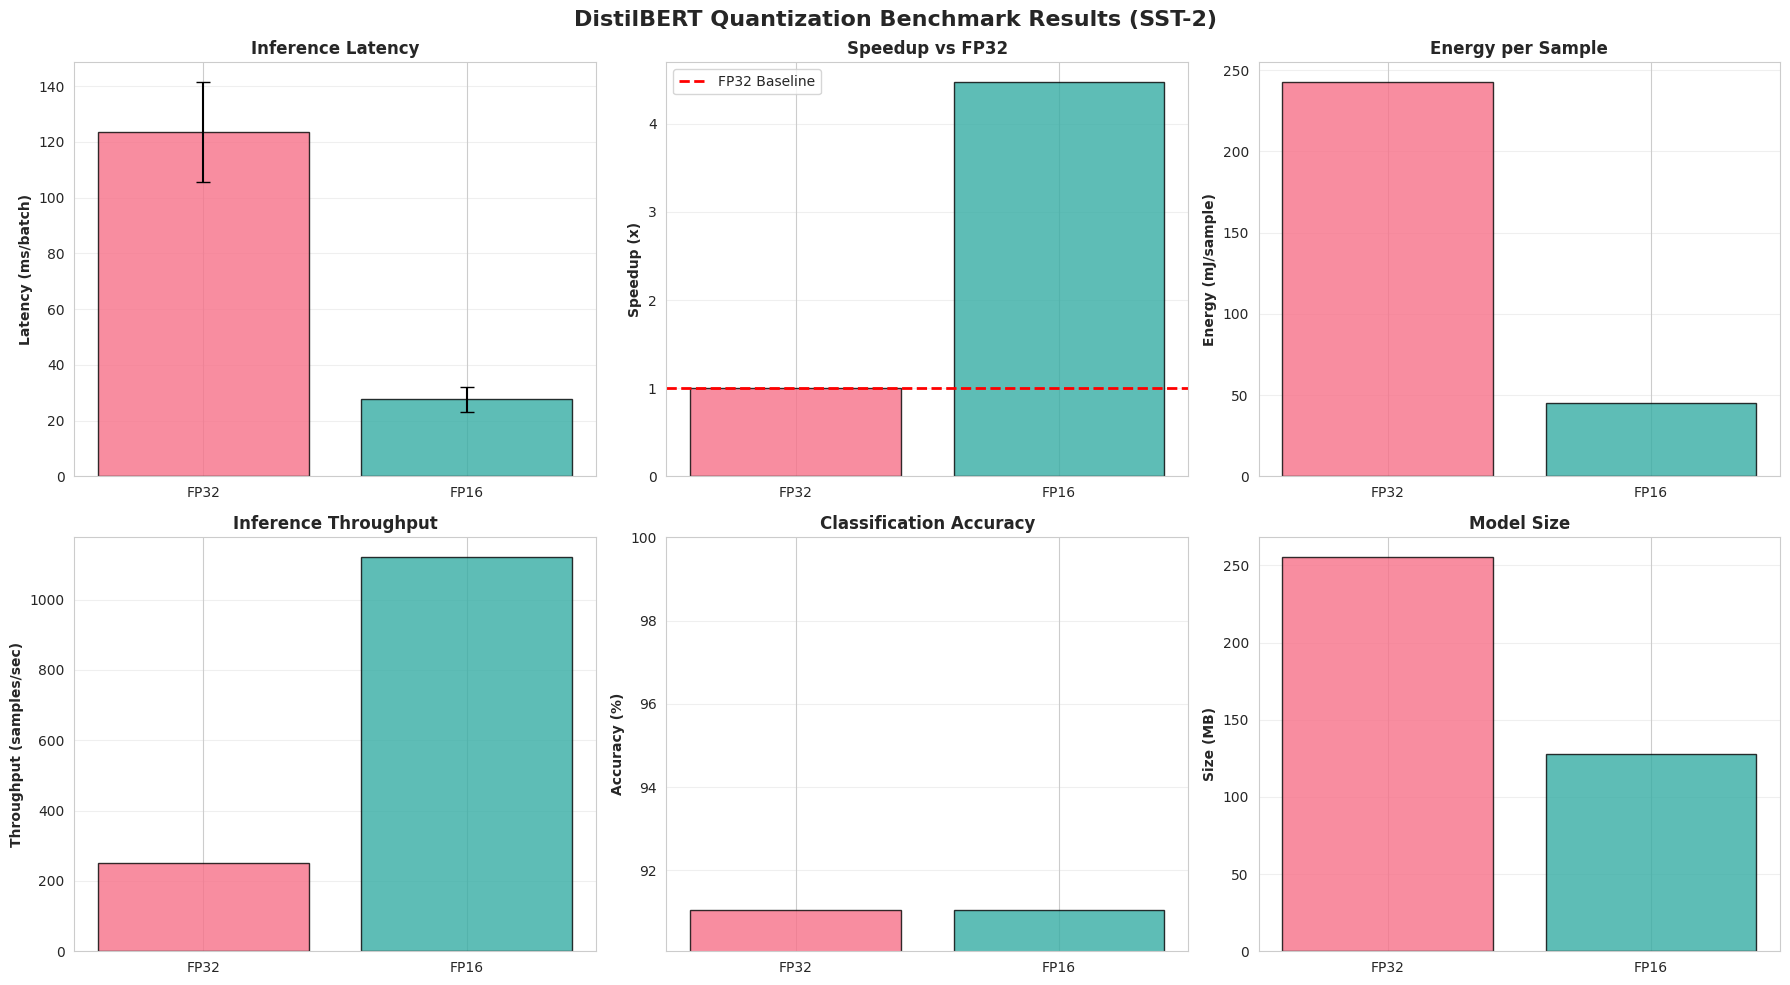

DistilBERT benchmark visualization complete


In [37]:
# Create comprehensive visualization for DistilBERT benchmarks
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('DistilBERT Quantization Benchmark Results (SST-2)', fontsize=16, fontweight='bold')

colors = sns.color_palette('husl', n_colors=len(df_distilbert))

# 1. Latency comparison
ax = axes[0, 0]
ax.bar(df_distilbert['name'], df_distilbert['mean_latency_ms'], color=colors, alpha=0.8, edgecolor='black')
ax.errorbar(df_distilbert['name'], df_distilbert['mean_latency_ms'], 
            yerr=df_distilbert['std_latency_ms'], fmt='none', color='black', capsize=5)
ax.set_ylabel('Latency (ms/batch)', fontweight='bold')
ax.set_title('Inference Latency', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 2. Speedup vs FP32
ax = axes[0, 1]
ax.bar(df_distilbert['name'], df_distilbert['speedup_vs_fp32'], color=colors, alpha=0.8, edgecolor='black')
ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='FP32 Baseline')
ax.set_ylabel('Speedup (x)', fontweight='bold')
ax.set_title('Speedup vs FP32', fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 3. Energy per sample
ax = axes[0, 2]
if df_distilbert['energy_per_sample_mj'].max() > 0:
    ax.bar(df_distilbert['name'], df_distilbert['energy_per_sample_mj'], color=colors, alpha=0.8, edgecolor='black')
    ax.set_ylabel('Energy (mJ/sample)', fontweight='bold')
    ax.set_title('Energy per Sample', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

# 4. Throughput
ax = axes[1, 0]
ax.bar(df_distilbert['name'], df_distilbert['throughput'], color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Throughput (samples/sec)', fontweight='bold')
ax.set_title('Inference Throughput', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 5. Accuracy
ax = axes[1, 1]
ax.bar(df_distilbert['name'], df_distilbert['accuracy'], color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Accuracy (%)', fontweight='bold')
ax.set_title('Classification Accuracy', fontweight='bold')
ax.set_ylim([min(df_distilbert['accuracy']) - 1, 100])
ax.grid(axis='y', alpha=0.3)

# 6. Model size
ax = axes[1, 2]
ax.bar(df_distilbert['name'], df_distilbert['model_size_mb'], color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Size (MB)', fontweight='bold')
ax.set_title('Model Size', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(output_dirs['distilbert'] / 'benchmark_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("DistilBERT benchmark visualization complete")

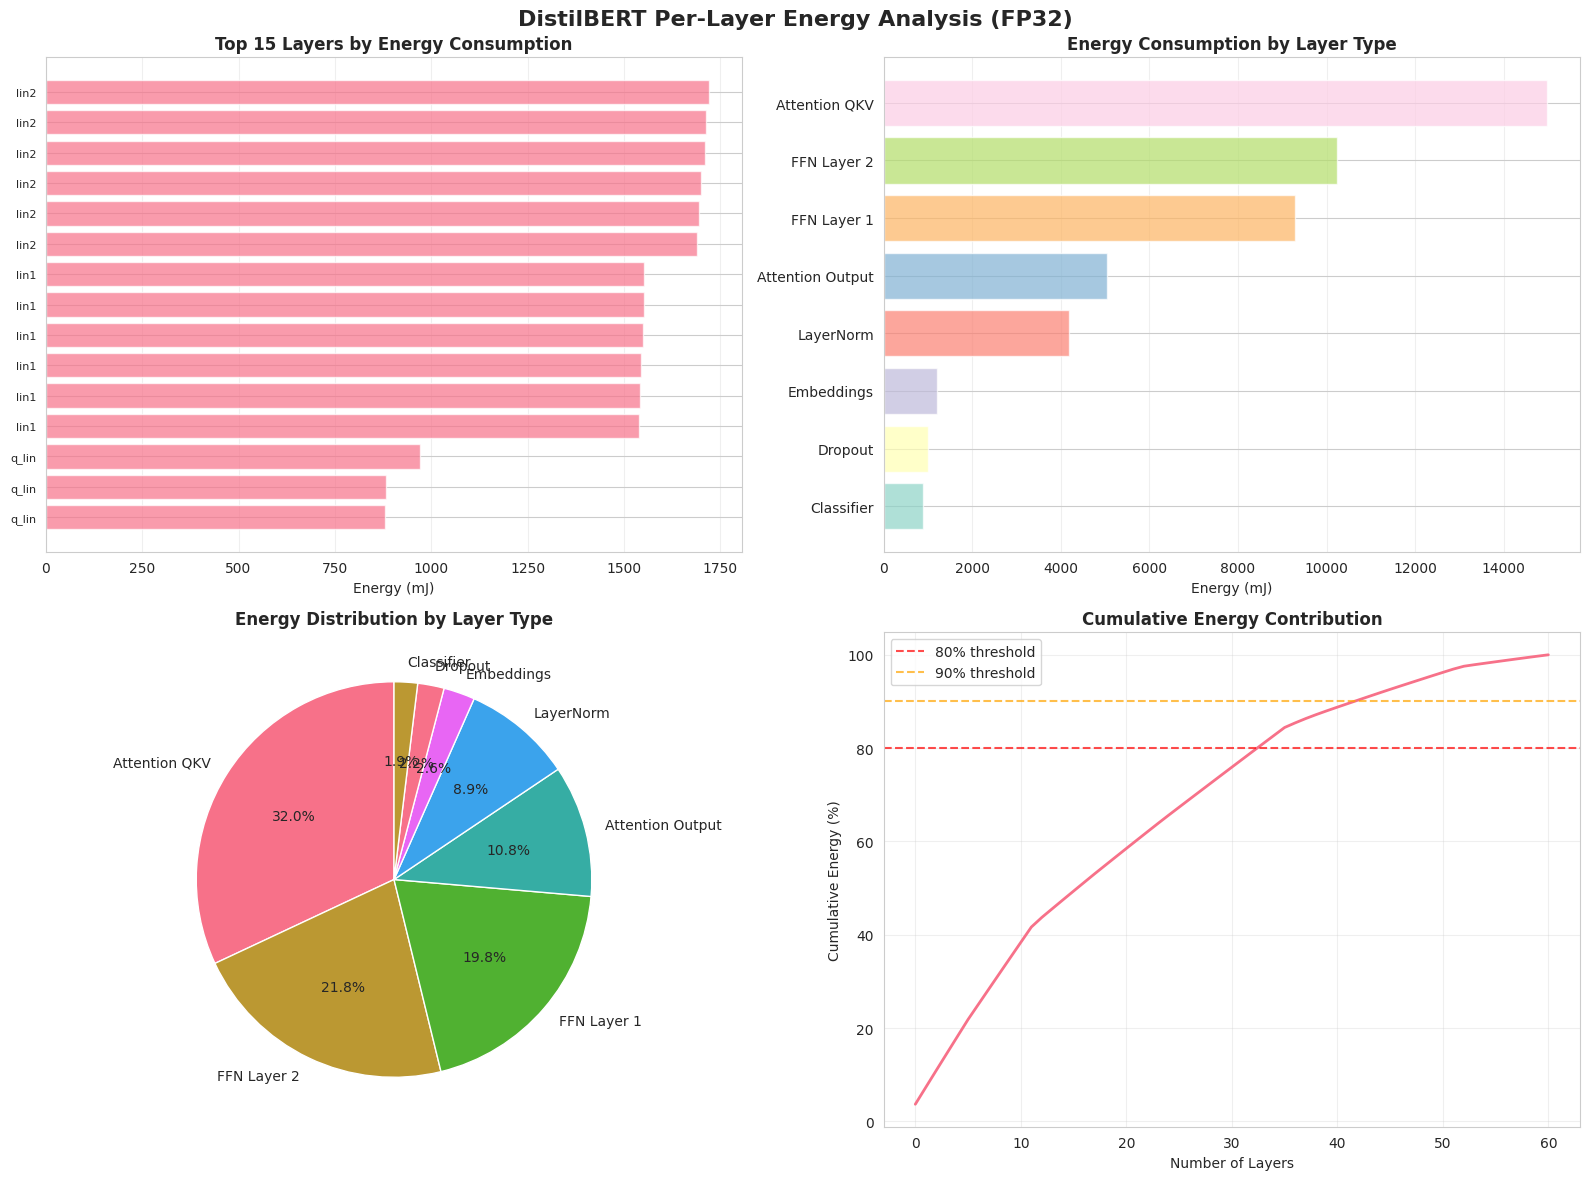

DistilBERT per-layer energy visualization complete


In [38]:
# DistilBERT Per-Layer Energy Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('DistilBERT Per-Layer Energy Analysis (FP32)', fontsize=16, fontweight='bold')

# 1. Top 15 layers by energy
ax = axes[0, 0]
top_layers = distilbert_layer_stats.head(15)
y_pos = range(len(top_layers))
ax.barh(y_pos, top_layers["energy_mj"], alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels([name.split('.')[-1] if len(name.split('.')) > 1 else name for name in top_layers["layer_name"]], fontsize=8)
ax.set_xlabel("Energy (mJ)", fontsize=10)
ax.set_title("Top 15 Layers by Energy Consumption", fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# 2. Energy by layer type
ax = axes[0, 1]
type_energy_sorted = distilbert_type_energy.sort_values("energy_mj", ascending=False)
y_pos = range(len(type_energy_sorted))
colors_type = plt.cm.Set3(range(len(type_energy_sorted)))
ax.barh(y_pos, type_energy_sorted["energy_mj"], alpha=0.7, color=colors_type)
ax.set_yticks(y_pos)
ax.set_yticklabels(type_energy_sorted.index, fontsize=10)
ax.invert_yaxis()
ax.set_xlabel("Energy (mJ)", fontsize=10)
ax.set_title("Energy Consumption by Layer Type", fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# 3. Pie chart of energy distribution
ax = axes[1, 0]
type_energy_pie = distilbert_type_energy[distilbert_type_energy["percent_energy"] > 1.0]
ax.pie(type_energy_pie["percent_energy"], labels=type_energy_pie.index, autopct='%1.1f%%', startangle=90)
ax.set_title("Energy Distribution by Layer Type", fontsize=12, fontweight='bold')

# 4. Cumulative energy contribution
ax = axes[1, 1]
cumulative = distilbert_layer_stats["energy_mj"].cumsum() / distilbert_layer_stats["energy_mj"].sum() * 100
ax.plot(range(len(cumulative)), cumulative, linewidth=2)
ax.axhline(y=80, color='r', linestyle='--', alpha=0.7, label='80% threshold')
ax.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
ax.set_xlabel("Number of Layers", fontsize=10)
ax.set_ylabel("Cumulative Energy (%)", fontsize=10)
ax.set_title("Cumulative Energy Contribution", fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(output_dirs['distilbert'] / 'per_layer_energy_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("DistilBERT per-layer energy visualization complete")

### Figure 3: Speed-Accuracy Trade-off


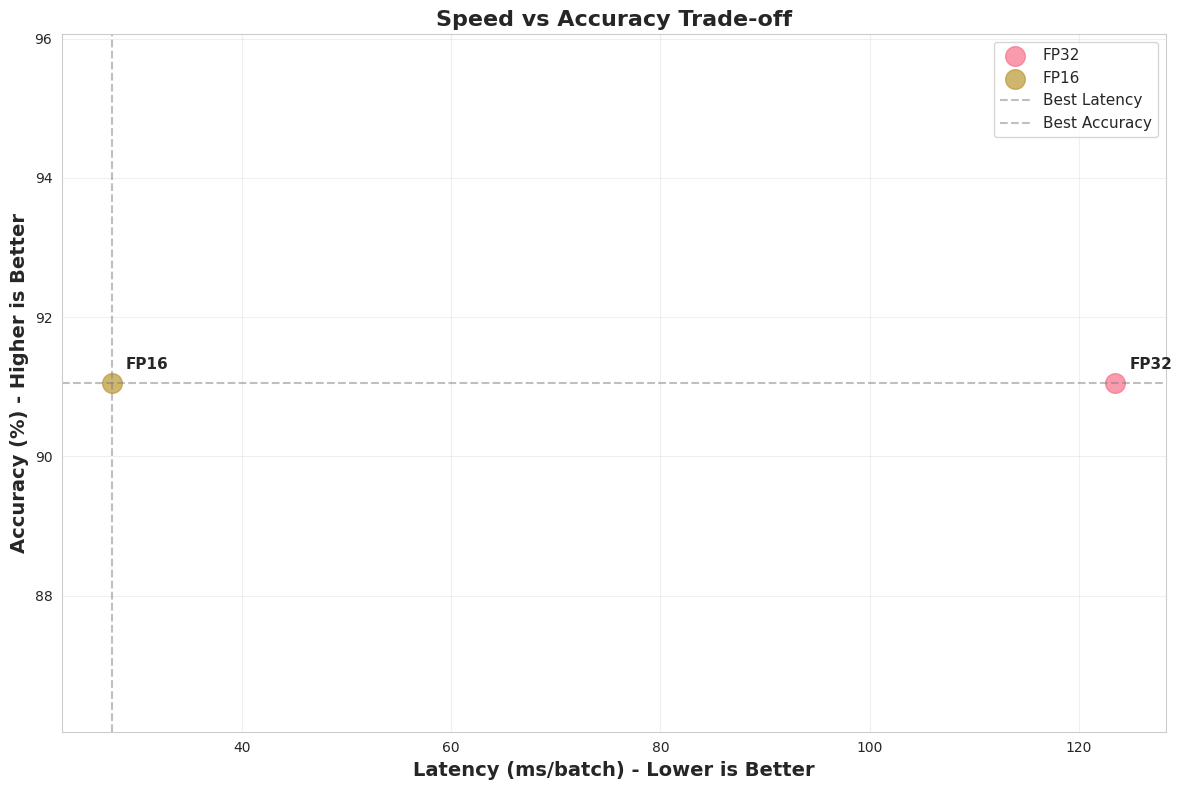

Speed-Accuracy Trade-off saved


In [39]:
# Figure 3: Speed-Accuracy Trade-off
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

for _, row in df_distilbert.iterrows():
    ax.scatter(row['mean_latency_ms'], row['accuracy'], s=200, alpha=0.7, label=row['name'])
    ax.annotate(row['name'], (row['mean_latency_ms'], row['accuracy']),
                xytext=(10, 10), textcoords='offset points', fontsize=11, fontweight='bold')

ax.set_xlabel('Latency (ms/batch) - Lower is Better', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy (%) - Higher is Better', fontsize=14, fontweight='bold')
ax.set_title('Speed vs Accuracy Trade-off', fontsize=16, fontweight='bold')

best_latency = df_distilbert['mean_latency_ms'].min()
best_accuracy = df_distilbert['accuracy'].max()
ax.axvline(x=best_latency, color='gray', linestyle='--', alpha=0.5, label='Best Latency')
ax.axhline(y=best_accuracy, color='gray', linestyle='--', alpha=0.5, label='Best Accuracy')

ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(output_dirs['distilbert'] / 'speed_accuracy_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

print("Speed-Accuracy Trade-off saved")


### Figure 6: Prediction Impact by Layer Type


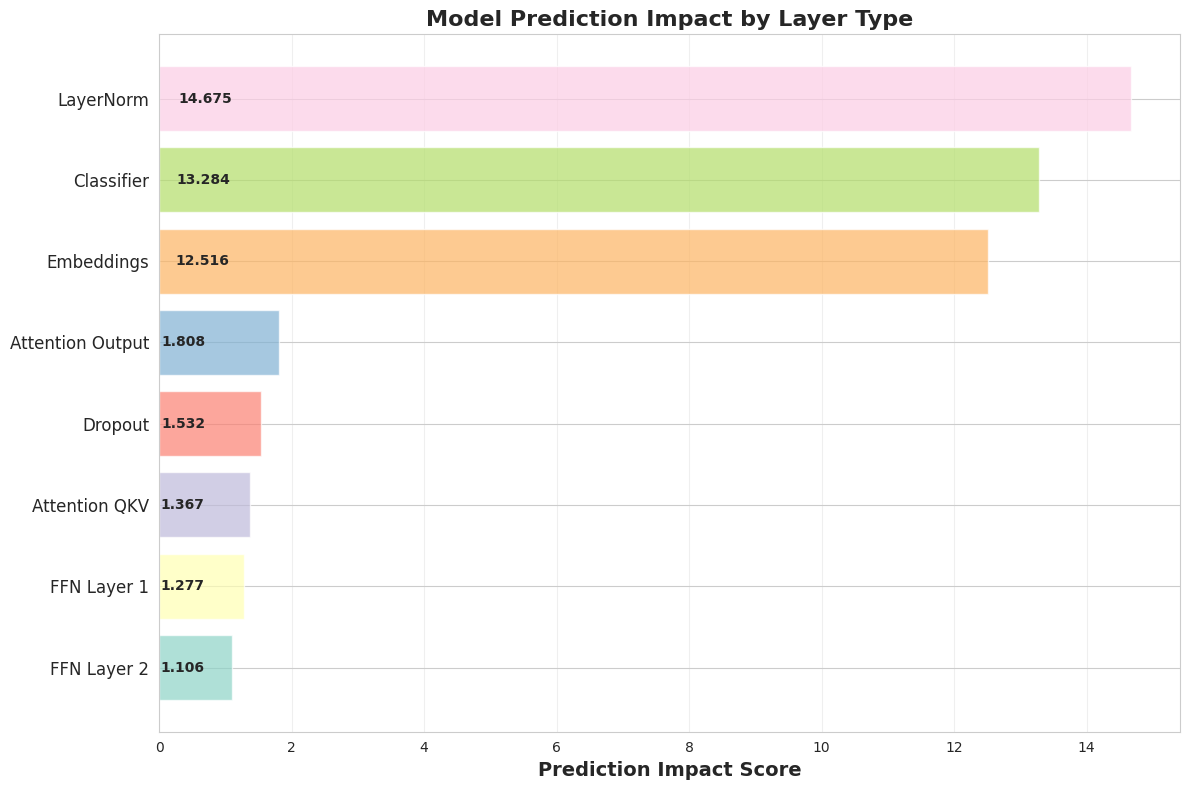

Prediction Impact by Layer Type saved


In [40]:
# Figure 6: Prediction Impact by Layer Type
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

type_impact_sorted = distilbert_type_impact.sort_values("impact_score", ascending=True)
y_pos = range(len(type_impact_sorted))
colors_type = plt.cm.Set3(range(len(type_impact_sorted)))

bars = ax.barh(y_pos, type_impact_sorted["impact_score"], alpha=0.7, color=colors_type)
ax.set_yticks(y_pos)
ax.set_yticklabels(type_impact_sorted.index, fontsize=12)
ax.invert_yaxis()
ax.set_xlabel("Prediction Impact Score", fontsize=14, fontweight='bold')
ax.set_title("Model Prediction Impact by Layer Type", fontsize=16, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(type_impact_sorted.iterrows()):
    ax.text(row["impact_score"] * 0.02, i, f'{row["impact_score"]:.3f}',
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(output_dirs['distilbert'] / 'prediction_impact_by_type.png', dpi=300, bbox_inches='tight')
plt.show()

print("Prediction Impact by Layer Type saved")


### Figure 7 & 8: Energy-Impact Correlation Analysis


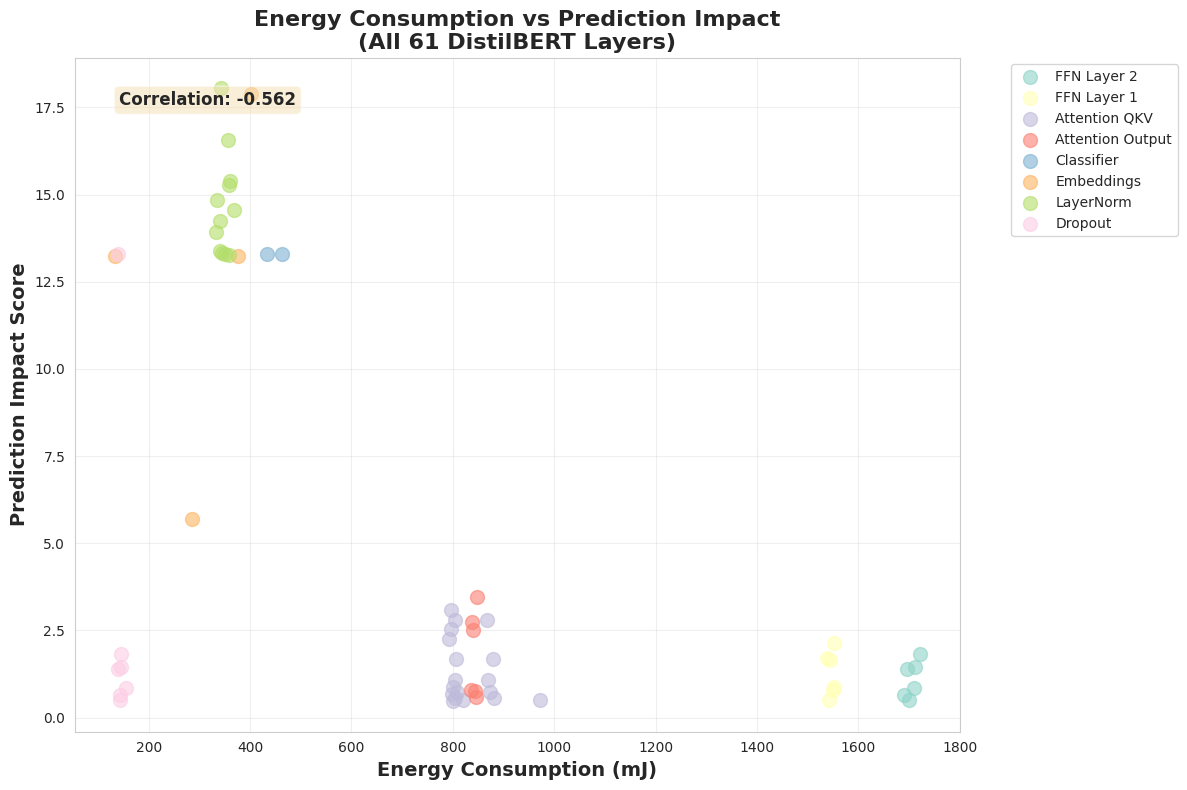

Energy vs Impact Scatter (correlation=-0.562)


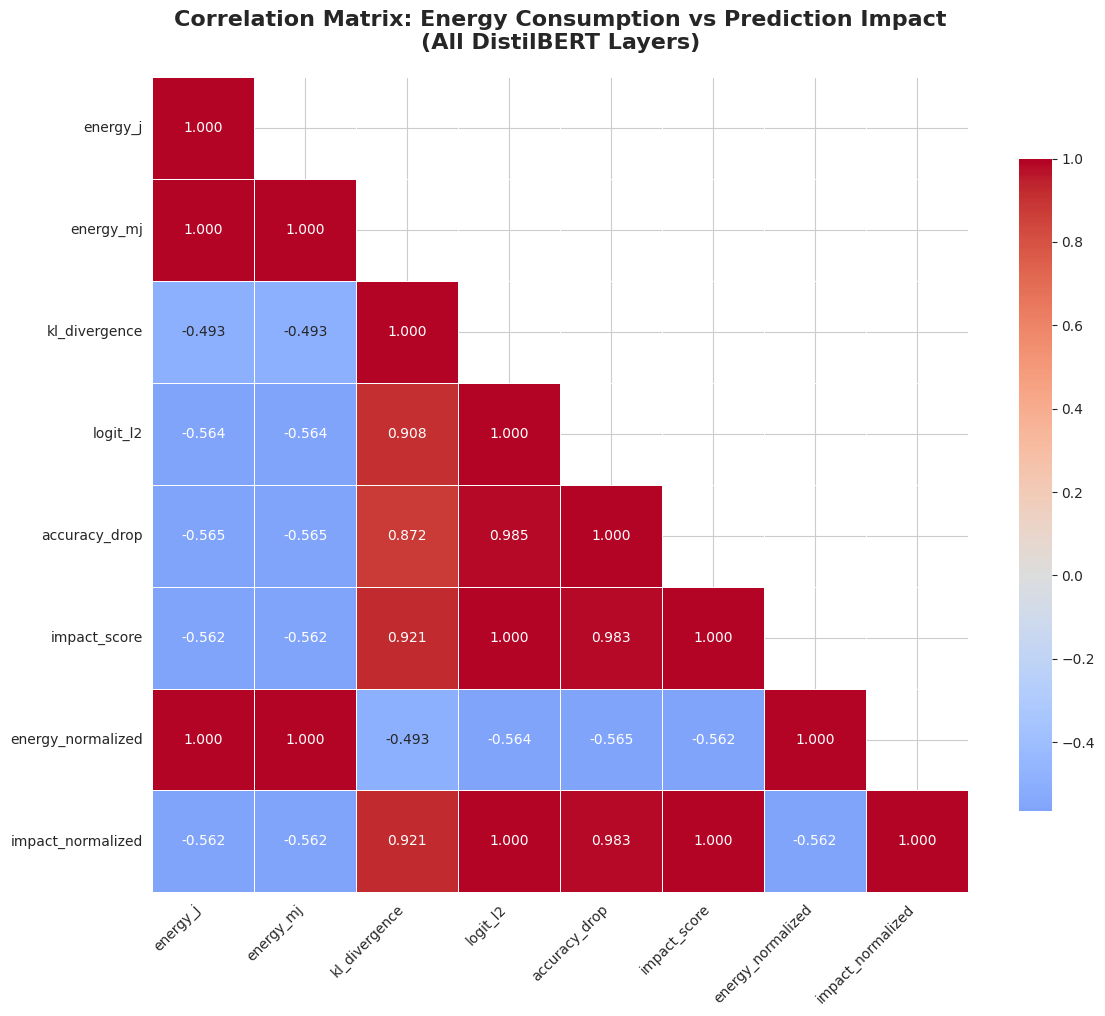

Correlation Matrix saved

 Merged data saved (61 layers)


In [41]:
# Merge energy and impact data
merged_distilbert = distilbert_layer_stats[["layer_name", "energy_j", "energy_mj", "layer_type"]].merge(
    distilbert_impact_df[["layer_name", "kl_divergence", "logit_l2", "accuracy_drop", "impact_score"]],
    on="layer_name",
    how="inner"
)

# Normalize for correlation
merged_distilbert["energy_normalized"] = (merged_distilbert["energy_mj"] - merged_distilbert["energy_mj"].min()) / \
                                          (merged_distilbert["energy_mj"].max() - merged_distilbert["energy_mj"].min())
merged_distilbert["impact_normalized"] = (merged_distilbert["impact_score"] - merged_distilbert["impact_score"].min()) / \
                                           (merged_distilbert["impact_score"].max() - merged_distilbert["impact_score"].min())

# Figure 7: Scatter plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

layer_types = merged_distilbert["layer_type"].unique()
colors_map = dict(zip(layer_types, plt.cm.Set3(range(len(layer_types)))))

for layer_type in layer_types:
    mask = merged_distilbert["layer_type"] == layer_type
    ax.scatter(
        merged_distilbert.loc[mask, "energy_mj"],
        merged_distilbert.loc[mask, "impact_score"],
        label=layer_type,
        alpha=0.6,
        s=100,
        color=colors_map[layer_type]
    )

ax.set_xlabel("Energy Consumption (mJ)", fontsize=14, fontweight='bold')
ax.set_ylabel("Prediction Impact Score", fontsize=14, fontweight='bold')
ax.set_title("Energy Consumption vs Prediction Impact\n(All {} DistilBERT Layers)".format(len(merged_distilbert)),
             fontsize=16, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(alpha=0.3)

corr_coef = merged_distilbert["energy_mj"].corr(merged_distilbert["impact_score"])
ax.text(0.05, 0.95, f'Correlation: {corr_coef:.3f}',
        transform=ax.transAxes, fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
        verticalalignment='top')

plt.tight_layout()
plt.savefig(output_dirs['distilbert'] / 'energy_vs_impact_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Energy vs Impact Scatter (correlation={corr_coef:.3f})")

# Figure 8: Correlation Matrix
corr_columns = ["energy_j", "energy_mj", "kl_divergence", "logit_l2", "accuracy_drop", "impact_score",
                "energy_normalized", "impact_normalized"]
corr_matrix = merged_distilbert[corr_columns].corr()

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    mask=mask,
    ax=ax
)

ax.set_title("Correlation Matrix: Energy Consumption vs Prediction Impact\n(All DistilBERT Layers)",
             fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig(output_dirs['distilbert'] / 'energy_impact_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Correlation Matrix saved")

# Save merged data
merged_distilbert.to_csv(output_dirs['distilbert'] / 'energy_impact_merged.csv', index=False)
print(f"\n Merged data saved ({len(merged_distilbert)} layers)")


## 3.2 GPT-2 Visualizations

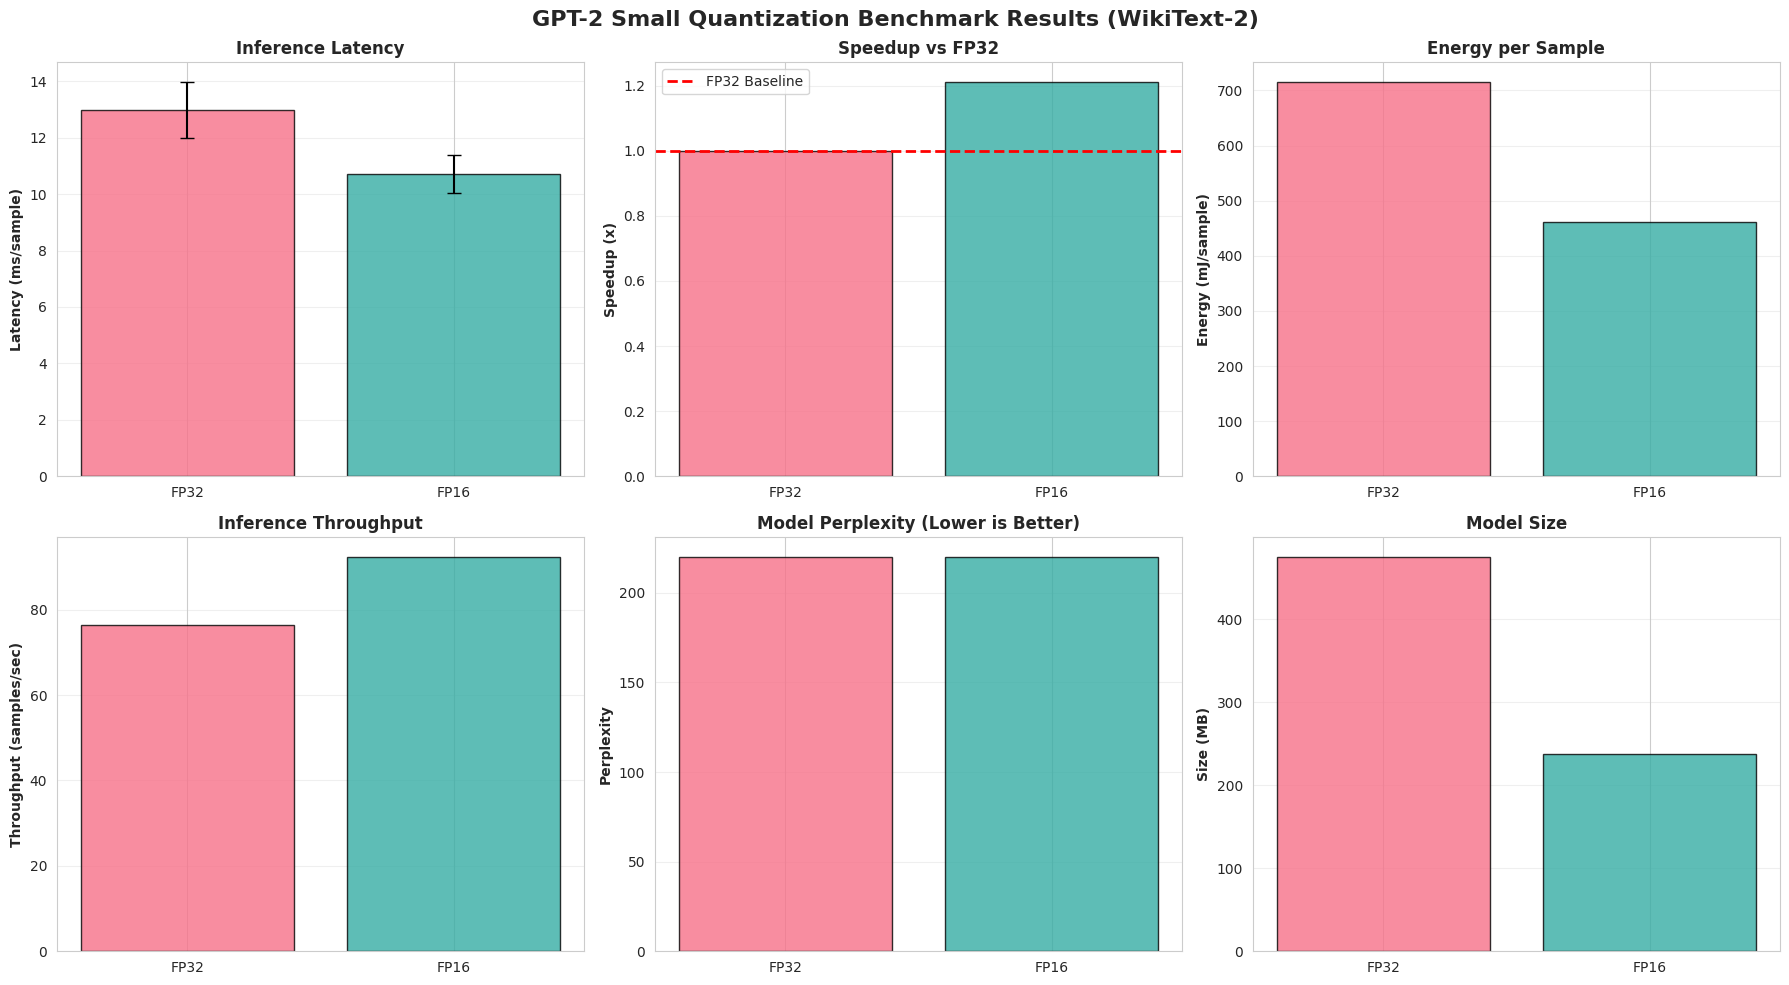

GPT-2 benchmark visualization complete


In [42]:
# Create comprehensive visualization for GPT-2 benchmarks
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('GPT-2 Small Quantization Benchmark Results (WikiText-2)', fontsize=16, fontweight='bold')

colors = sns.color_palette('husl', n_colors=len(df_gpt2))

# 1. Latency comparison
ax = axes[0, 0]
ax.bar(df_gpt2['name'], df_gpt2['mean_latency_ms'], color=colors, alpha=0.8, edgecolor='black')
ax.errorbar(df_gpt2['name'], df_gpt2['mean_latency_ms'], 
            yerr=df_gpt2['std_latency_ms'], fmt='none', color='black', capsize=5)
ax.set_ylabel('Latency (ms/sample)', fontweight='bold')
ax.set_title('Inference Latency', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 2. Speedup vs FP32
ax = axes[0, 1]
ax.bar(df_gpt2['name'], df_gpt2['speedup_vs_fp32'], color=colors, alpha=0.8, edgecolor='black')
ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='FP32 Baseline')
ax.set_ylabel('Speedup (x)', fontweight='bold')
ax.set_title('Speedup vs FP32', fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 3. Energy per sample
ax = axes[0, 2]
if df_gpt2['energy_per_sample_mj'].max() > 0:
    ax.bar(df_gpt2['name'], df_gpt2['energy_per_sample_mj'], color=colors, alpha=0.8, edgecolor='black')
    ax.set_ylabel('Energy (mJ/sample)', fontweight='bold')
    ax.set_title('Energy per Sample', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

# 4. Throughput
ax = axes[1, 0]
ax.bar(df_gpt2['name'], df_gpt2['throughput'], color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Throughput (samples/sec)', fontweight='bold')
ax.set_title('Inference Throughput', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 5. Perplexity
ax = axes[1, 1]
ax.bar(df_gpt2['name'], df_gpt2['perplexity'], color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Perplexity', fontweight='bold')
ax.set_title('Model Perplexity (Lower is Better)', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 6. Model size
ax = axes[1, 2]
ax.bar(df_gpt2['name'], df_gpt2['model_size_mb'], color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Size (MB)', fontweight='bold')
ax.set_title('Model Size', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(output_dirs['gpt2'] / 'benchmark_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("GPT-2 benchmark visualization complete")

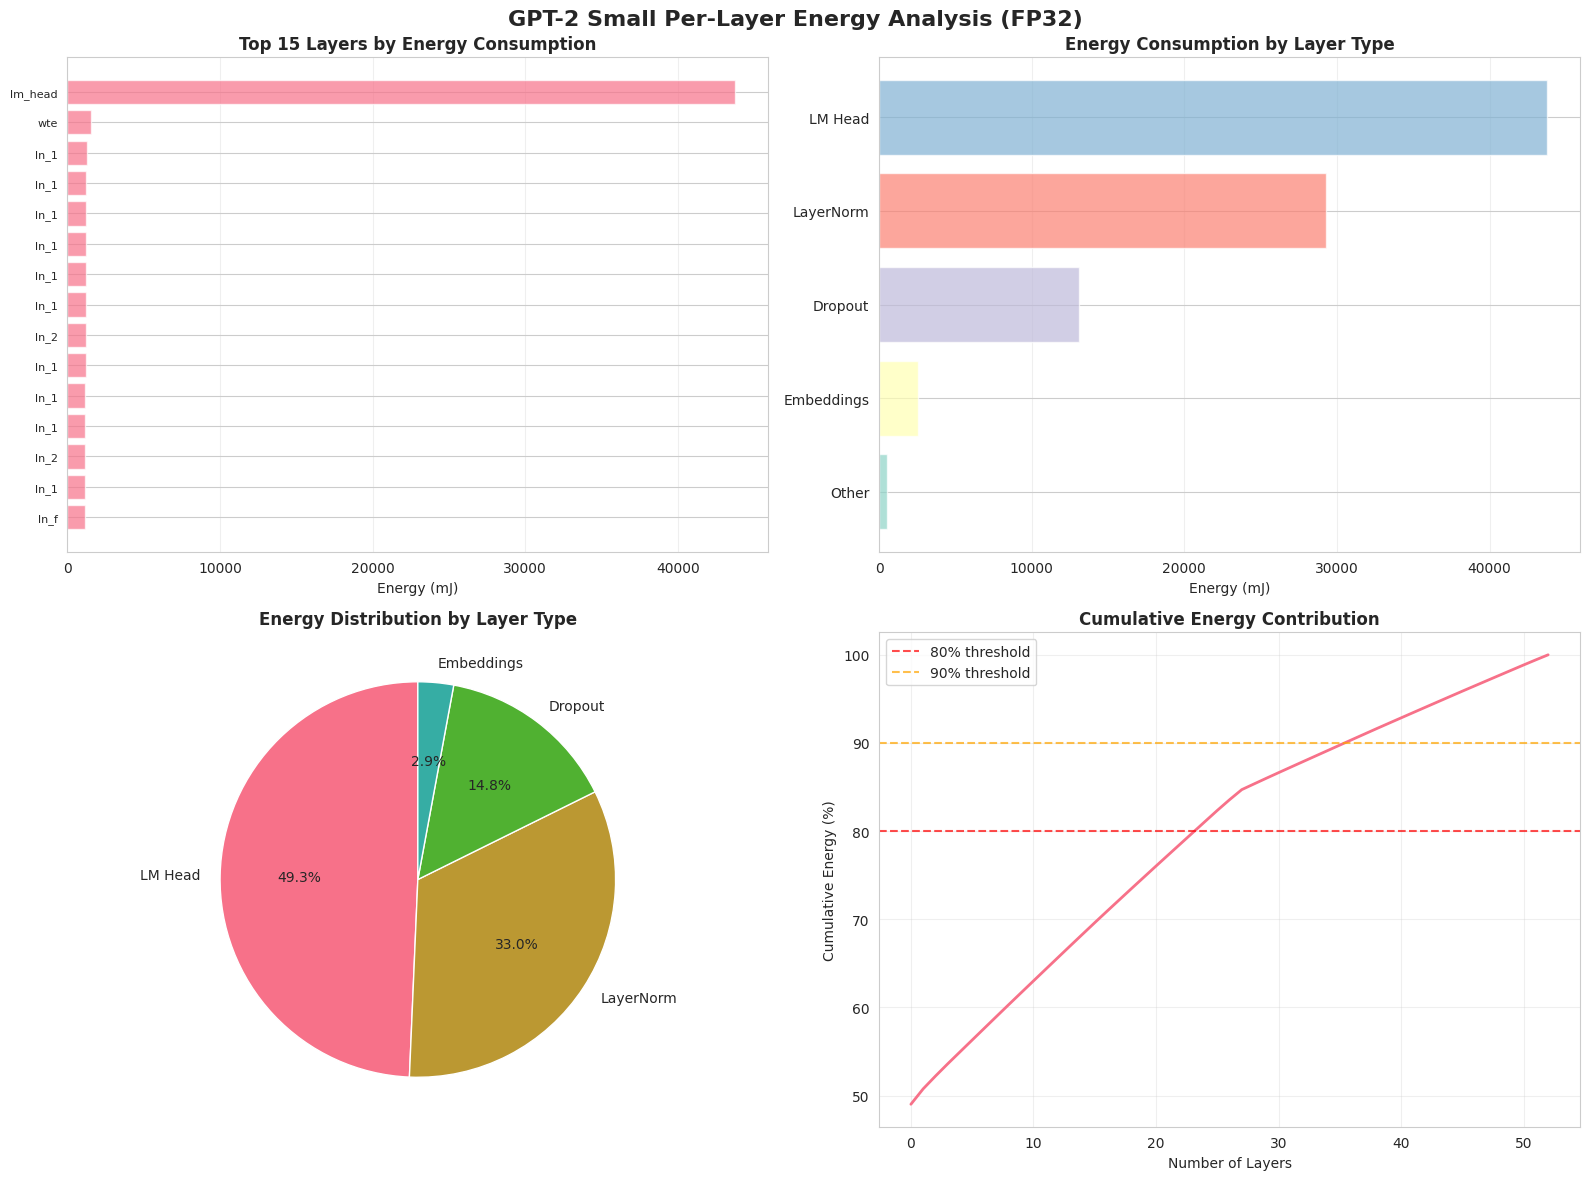

GPT-2 per-layer energy visualization complete


In [43]:
# GPT-2 Per-Layer Energy Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('GPT-2 Small Per-Layer Energy Analysis (FP32)', fontsize=16, fontweight='bold')

# 1. Top 15 layers by energy
ax = axes[0, 0]
top_layers = gpt2_layer_stats.head(15)
y_pos = range(len(top_layers))
ax.barh(y_pos, top_layers["energy_mj"], alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels([name.split('.')[-1] if len(name.split('.')) > 1 else name for name in top_layers["layer_name"]], fontsize=8)
ax.set_xlabel("Energy (mJ)", fontsize=10)
ax.set_title("Top 15 Layers by Energy Consumption", fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# 2. Energy by layer type
ax = axes[0, 1]
type_energy_sorted = gpt2_type_energy.sort_values("energy_mj", ascending=True)
y_pos = range(len(type_energy_sorted))
colors_type = plt.cm.Set3(range(len(type_energy_sorted)))
ax.barh(y_pos, type_energy_sorted["energy_mj"], alpha=0.7, color=colors_type)
ax.set_yticks(y_pos)
ax.set_yticklabels(type_energy_sorted.index, fontsize=10)
ax.set_xlabel("Energy (mJ)", fontsize=10)
ax.set_title("Energy Consumption by Layer Type", fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# 3. Pie chart of energy distribution
ax = axes[1, 0]
type_energy_pie = gpt2_type_energy[gpt2_type_energy["percent_energy"] > 1.0]
ax.pie(type_energy_pie["percent_energy"], labels=type_energy_pie.index, autopct='%1.1f%%', startangle=90)
ax.set_title("Energy Distribution by Layer Type", fontsize=12, fontweight='bold')

# 4. Cumulative energy contribution
ax = axes[1, 1]
cumulative = gpt2_layer_stats["energy_mj"].cumsum() / gpt2_layer_stats["energy_mj"].sum() * 100
ax.plot(range(len(cumulative)), cumulative, linewidth=2)
ax.axhline(y=80, color='r', linestyle='--', alpha=0.7, label='80% threshold')
ax.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
ax.set_xlabel("Number of Layers", fontsize=10)
ax.set_ylabel("Cumulative Energy (%)", fontsize=10)
ax.set_title("Cumulative Energy Contribution", fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(output_dirs['gpt2'] / 'per_layer_energy_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("GPT-2 per-layer energy visualization complete")

### Figure 10: GPT-2 Prediction Impact by Layer Type


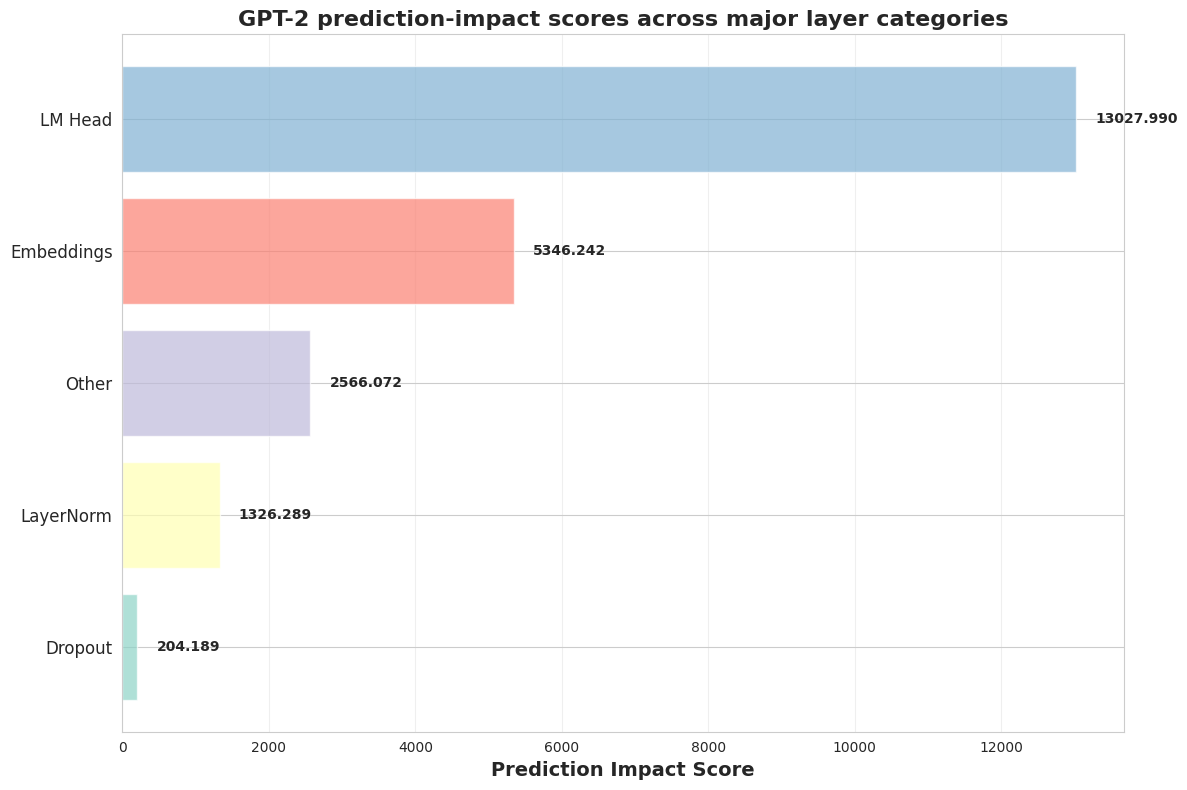

GPT-2 Prediction Impact by Layer Type saved


In [44]:
# Figure 10: GPT-2 Prediction Impact by Layer Type
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

type_impact_sorted = gpt2_type_impact.sort_values("impact_score", ascending=True)
y_pos = range(len(type_impact_sorted))
colors_type = plt.cm.Set3(range(len(type_impact_sorted)))

bars = ax.barh(y_pos, type_impact_sorted["impact_score"], alpha=0.7, color=colors_type)
ax.set_yticks(y_pos)
ax.set_yticklabels(type_impact_sorted.index, fontsize=12)
ax.set_xlabel("Prediction Impact Score", fontsize=14, fontweight='bold')
ax.set_title("GPT-2 prediction-impact scores across major layer categories", fontsize=16, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(type_impact_sorted.iterrows()):
    ax.text(row["impact_score"] + (type_impact_sorted["impact_score"].max() * 0.02), i,
            f'{row["impact_score"]:.3f}',
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(output_dirs['gpt2'] / 'prediction_impact_by_type.png', dpi=300, bbox_inches='tight')
plt.show()

print("GPT-2 Prediction Impact by Layer Type saved")


### Figure 11 & 12: GPT-2 Energy-Impact Correlation Analysis


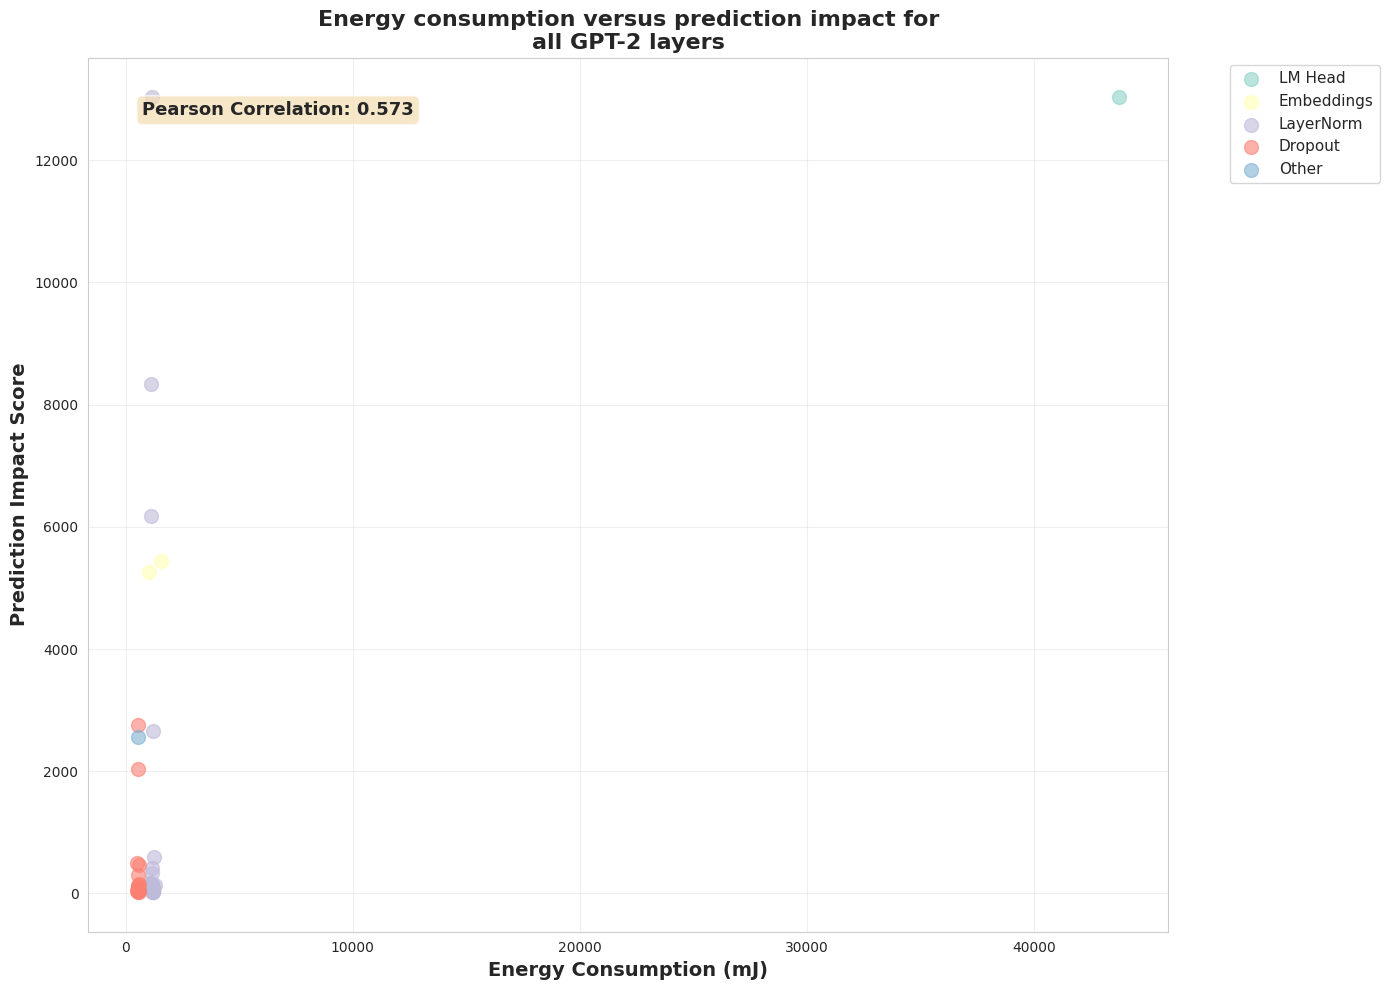

Energy vs Impact Scatter (correlation=0.573)


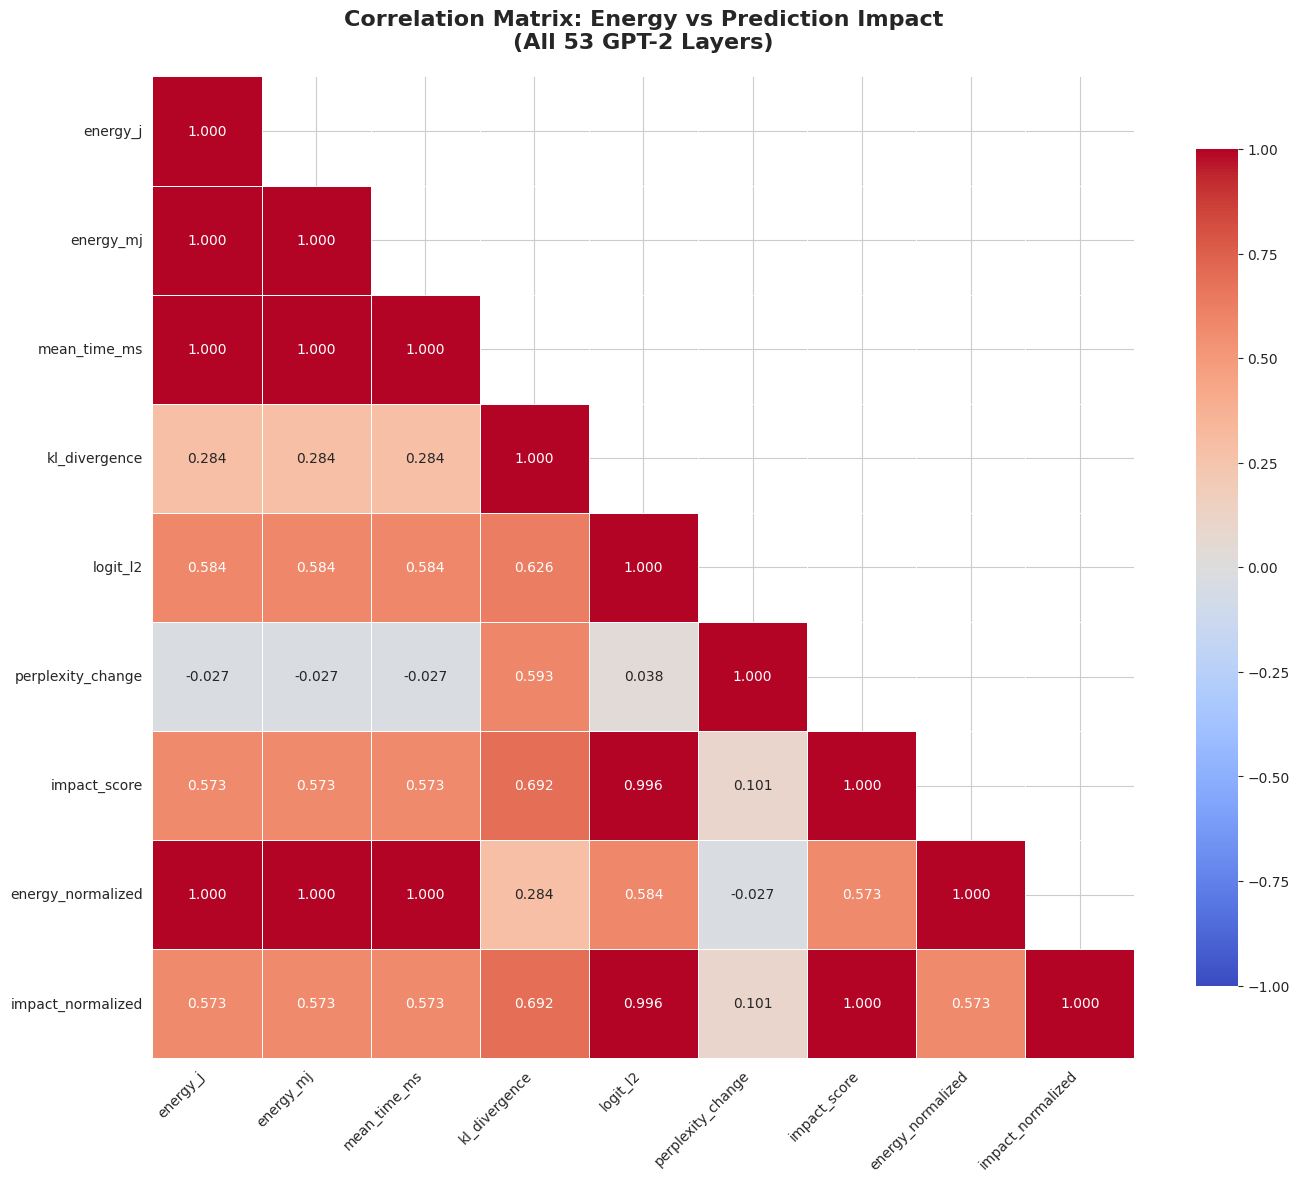

Correlation Matrix saved

 Key Correlations (GPT-2):
  Energy vs Impact Score:      0.5727
  Energy vs KL Divergence:     0.2842
  Energy vs Logit L2:          0.5840

 Merged data saved (53 layers)


In [45]:
# Merge energy and impact data
merged_gpt2 = gpt2_layer_stats[["layer_name", "energy_j", "energy_mj", "mean_time_ms", "layer_type"]].merge(
    gpt2_impact_df[["layer_name", "kl_divergence", "logit_l2", "perplexity_change", "impact_score"]],
    on="layer_name",
    how="inner"
)

# Normalize for correlation
merged_gpt2["energy_normalized"] = (merged_gpt2["energy_mj"] - merged_gpt2["energy_mj"].min()) / \
                                    (merged_gpt2["energy_mj"].max() - merged_gpt2["energy_mj"].min())
merged_gpt2["impact_normalized"] = (merged_gpt2["impact_score"] - merged_gpt2["impact_score"].min()) / \
                                     (merged_gpt2["impact_score"].max() - merged_gpt2["impact_score"].min())

# Figure 11: Scatter plot
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

layer_types = merged_gpt2["layer_type"].unique()
colors_map = dict(zip(layer_types, plt.cm.Set3(range(len(layer_types)))))

for layer_type in layer_types:
    mask = merged_gpt2["layer_type"] == layer_type
    ax.scatter(
        merged_gpt2.loc[mask, "energy_mj"],
        merged_gpt2.loc[mask, "impact_score"],
        label=layer_type,
        alpha=0.6,
        s=100,
        color=colors_map[layer_type]
    )

ax.set_xlabel("Energy Consumption (mJ)", fontsize=14, fontweight='bold')
ax.set_ylabel("Prediction Impact Score", fontsize=14, fontweight='bold')
ax.set_title("Energy consumption versus prediction impact for\nall GPT-2 layers",
             fontsize=16, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)
ax.grid(alpha=0.3)

corr_coef = merged_gpt2["energy_mj"].corr(merged_gpt2["impact_score"])
ax.text(0.05, 0.95, f'Pearson Correlation: {corr_coef:.3f}',
        transform=ax.transAxes, fontsize=13, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7),
        verticalalignment='top')

plt.tight_layout()
plt.savefig(output_dirs['gpt2'] / 'energy_vs_impact_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Energy vs Impact Scatter (correlation={corr_coef:.3f})")

# Figure 12: Correlation Matrix
corr_columns = ["energy_j", "energy_mj", "mean_time_ms", "kl_divergence", "logit_l2",
                "perplexity_change", "impact_score", "energy_normalized", "impact_normalized"]
corr_matrix = merged_gpt2[corr_columns].corr()

fig, ax = plt.subplots(1, 1, figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    mask=mask,
    ax=ax,
    vmin=-1,
    vmax=1
)

ax.set_title("Correlation Matrix: Energy vs Prediction Impact\n(All {} GPT-2 Layers)".format(len(merged_gpt2)),
             fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig(output_dirs['gpt2'] / 'energy_impact_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Correlation Matrix saved")

# Print correlation insights
print(f"\n Key Correlations (GPT-2):")
print(f"  Energy vs Impact Score:      {corr_matrix.loc['energy_mj', 'impact_score']:.4f}")
print(f"  Energy vs KL Divergence:     {corr_matrix.loc['energy_mj', 'kl_divergence']:.4f}")
print(f"  Energy vs Logit L2:          {corr_matrix.loc['energy_mj', 'logit_l2']:.4f}")

# Save merged data
merged_gpt2.to_csv(output_dirs['gpt2'] / 'energy_impact_merged.csv', index=False)
print(f"\n Merged data saved ({len(merged_gpt2)} layers)")


## 3.3 Comparative Analysis: DistilBERT vs GPT-2

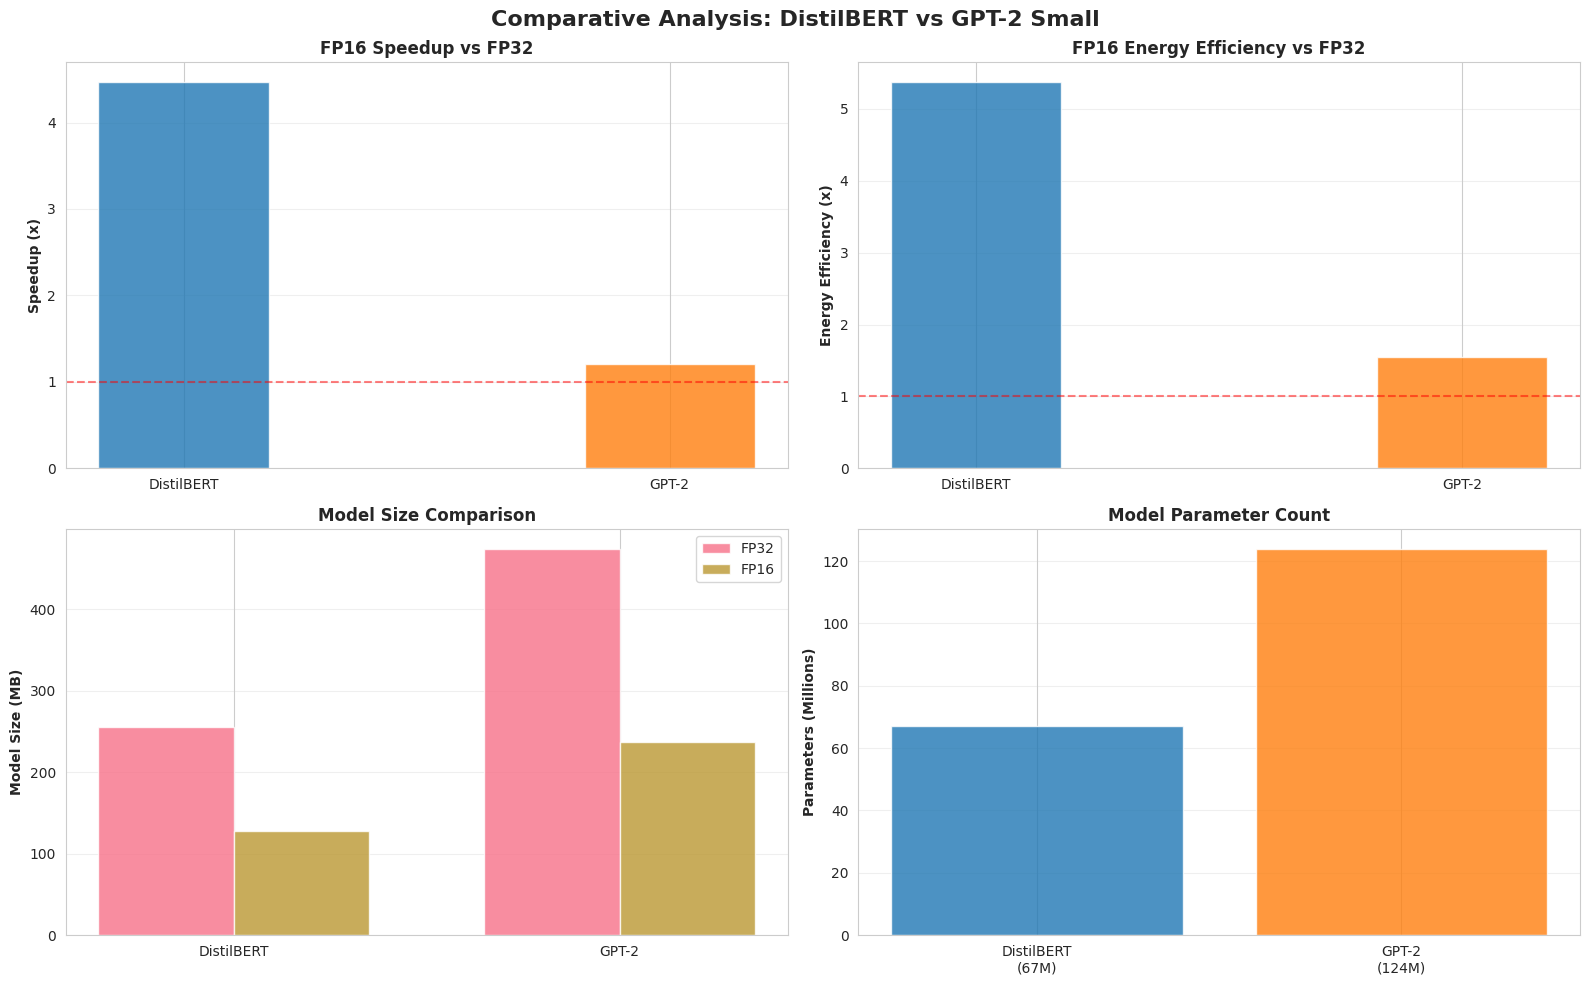

Comparative analysis visualization complete


In [46]:
# Create side-by-side comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Comparative Analysis: DistilBERT vs GPT-2 Small', fontsize=16, fontweight='bold')

# 1. Speedup comparison
ax = axes[0, 0]
x = np.arange(2)
width = 0.35
distilbert_fp16_speedup = df_distilbert[df_distilbert['name'] == 'FP16']['speedup_vs_fp32'].values[0]
gpt2_fp16_speedup = df_gpt2[df_gpt2['name'] == 'FP16']['speedup_vs_fp32'].values[0]
ax.bar(x[0], distilbert_fp16_speedup, width, label='DistilBERT', color='#1f77b4', alpha=0.8)
ax.bar(x[1], gpt2_fp16_speedup, width, label='GPT-2', color='#ff7f0e', alpha=0.8)
ax.set_ylabel('Speedup (x)', fontweight='bold')
ax.set_title('FP16 Speedup vs FP32', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['DistilBERT', 'GPT-2'])
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5)
ax.grid(axis='y', alpha=0.3)

# 2. Energy efficiency comparison
ax = axes[0, 1]
distilbert_fp16_energy_eff = df_distilbert[df_distilbert['name'] == 'FP16']['energy_reduction_vs_fp32'].values[0]
gpt2_fp16_energy_eff = df_gpt2[df_gpt2['name'] == 'FP16']['energy_reduction_vs_fp32'].values[0]
ax.bar(x[0], distilbert_fp16_energy_eff, width, label='DistilBERT', color='#1f77b4', alpha=0.8)
ax.bar(x[1], gpt2_fp16_energy_eff, width, label='GPT-2', color='#ff7f0e', alpha=0.8)
ax.set_ylabel('Energy Efficiency (x)', fontweight='bold')
ax.set_title('FP16 Energy Efficiency vs FP32', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['DistilBERT', 'GPT-2'])
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5)
ax.grid(axis='y', alpha=0.3)

# 3. Model size comparison
ax = axes[1, 0]
distilbert_fp32_size = df_distilbert[df_distilbert['name'] == 'FP32']['model_size_mb'].values[0]
distilbert_fp16_size = df_distilbert[df_distilbert['name'] == 'FP16']['model_size_mb'].values[0]
gpt2_fp32_size = df_gpt2[df_gpt2['name'] == 'FP32']['model_size_mb'].values[0]
gpt2_fp16_size = df_gpt2[df_gpt2['name'] == 'FP16']['model_size_mb'].values[0]

x_pos = np.arange(2)
width = 0.35
ax.bar(x_pos - width/2, [distilbert_fp32_size, gpt2_fp32_size], width, label='FP32', alpha=0.8)
ax.bar(x_pos + width/2, [distilbert_fp16_size, gpt2_fp16_size], width, label='FP16', alpha=0.8)
ax.set_ylabel('Model Size (MB)', fontweight='bold')
ax.set_title('Model Size Comparison', fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(['DistilBERT', 'GPT-2'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 4. Number of parameters
ax = axes[1, 1]
params = [67, 124]  # DistilBERT: 67M, GPT-2: 124M
ax.bar(x, params, color=['#1f77b4', '#ff7f0e'], alpha=0.8)
ax.set_ylabel('Parameters (Millions)', fontweight='bold')
ax.set_title('Model Parameter Count', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['DistilBERT\n(67M)', 'GPT-2\n(124M)'])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(output_dirs['base'] / 'comparative_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Comparative analysis visualization complete")

## 3.4 Summary Statistics and Report

In [47]:
print("\n DISTILBERT (SST-2 Sentiment Classification)")

for _, row in df_distilbert.iterrows():
    print(f"\n{row['name']}:")
    print(f"  Latency:    {row['mean_latency_ms']:.2f} ± {row['std_latency_ms']:.2f} ms/batch")
    print(f"  Throughput: {row['throughput']:.1f} samples/sec")
    print(f"  Accuracy:   {row['accuracy']:.2f}%")
    print(f"  Energy:     {row['energy_per_sample_mj']:.2f} mJ/sample")
    print(f"  Model Size: {row['model_size_mb']:.2f} MB")
    if row['name'] == 'FP16':
        print(f"  Speedup:    {row['speedup_vs_fp32']:.2f}x faster")
        print(f"  Energy Eff: {row['energy_reduction_vs_fp32']:.2f}x more efficient")

print("\n GPT-2 SMALL (WikiText-2 Language Modeling)")

for _, row in df_gpt2.iterrows():
    print(f"\n{row['name']}:")
    print(f"  Latency:     {row['mean_latency_ms']:.2f} ± {row['std_latency_ms']:.2f} ms/sample")
    print(f"  Throughput:  {row['throughput']:.1f} samples/sec")
    print(f"  Tokens/sec:  {row['tokens_per_sec']:.1f}")
    print(f"  Perplexity:  {row['perplexity']:.2f}")
    print(f"  Energy:      {row['energy_per_sample_mj']:.2f} mJ/sample")
    print(f"  Model Size:  {row['model_size_mb']:.2f} MB")
    if row['name'] == 'FP16':
        print(f"  Speedup:     {row['speedup_vs_fp32']:.2f}x faster")
        print(f"  Energy Eff:  {row['energy_reduction_vs_fp32']:.2f}x more efficient")

print("\n KEY FINDINGS")

print("\n1. FP16 quantization provides significant benefits:")
print(f"   - DistilBERT: {df_distilbert[df_distilbert['name']=='FP16']['speedup_vs_fp32'].values[0]:.2f}x speedup, {df_distilbert[df_distilbert['name']=='FP16']['energy_reduction_vs_fp32'].values[0]:.2f}x energy reduction")
print(f"   - GPT-2:      {df_gpt2[df_gpt2['name']=='FP16']['speedup_vs_fp32'].values[0]:.2f}x speedup, {df_gpt2[df_gpt2['name']=='FP16']['energy_reduction_vs_fp32'].values[0]:.2f}x energy reduction")
print("\n2. No quality degradation observed:")
print(f"   - DistilBERT accuracy unchanged: {df_distilbert[df_distilbert['name']=='FP32']['accuracy'].values[0]:.2f}% (FP32) vs {df_distilbert[df_distilbert['name']=='FP16']['accuracy'].values[0]:.2f}% (FP16)")
print(f"   - GPT-2 perplexity nearly identical: {df_gpt2[df_gpt2['name']=='FP32']['perplexity'].values[0]:.2f} (FP32) vs {df_gpt2[df_gpt2['name']=='FP16']['perplexity'].values[0]:.2f} (FP16)")
print("\n3. Model size reduced by 50% with FP16")
print("\n4. Per-layer profiling identifies quantization candidates")

print("\n All results saved to:", output_dirs['base'])
print("  - DistilBERT results:", output_dirs['distilbert'])
print("  - GPT-2 results:     ", output_dirs['gpt2'])
print("  - Datasets:          ", output_dirs['datasets'])


 DISTILBERT (SST-2 Sentiment Classification)

FP32:
  Latency:    123.48 ± 17.99 ms/batch
  Throughput: 251.7 samples/sec
  Accuracy:   91.06%
  Energy:     242.60 mJ/sample
  Model Size: 255.41 MB

FP16:
  Latency:    27.60 ± 4.36 ms/batch
  Throughput: 1120.9 samples/sec
  Accuracy:   91.06%
  Energy:     45.09 mJ/sample
  Model Size: 127.71 MB
  Speedup:    4.47x faster
  Energy Eff: 5.38x more efficient

 GPT-2 SMALL (WikiText-2 Language Modeling)

FP32:
  Latency:     12.98 ± 0.99 ms/sample
  Throughput:  76.3 samples/sec
  Tokens/sec:  7766.3
  Perplexity:  219.94
  Energy:      715.19 mJ/sample
  Model Size:  474.70 MB

FP16:
  Latency:     10.72 ± 0.68 ms/sample
  Throughput:  92.3 samples/sec
  Tokens/sec:  9393.4
  Perplexity:  219.93
  Energy:      462.16 mJ/sample
  Model Size:  237.35 MB
  Speedup:     1.21x faster
  Energy Eff:  1.55x more efficient

 KEY FINDINGS

1. FP16 quantization provides significant benefits:
   - DistilBERT: 4.47x speedup, 5.38x energy reduction
